# Исследование проведения выборов в Википедии

## Описание проекта:

**Цели проекта:** 
- Исследовать данные проведения выборов в Википедии, обнаружить в них значимые инсайты
- Сегментировать пользователей, изучить статистики сегментов
- Описать и визуализировать основные находки

**Данные:**

Сайт, с которого собиралась статистика — [wikiscan.org](https://ru.wikiscan.org/)

**wiki_arbcom.xlsx** - информация о голосовании
* voter - ник голосовавшего юзера     
* can_vote - считался ли его голос действующим
* time - когда был отдан голос
* candidate - ник кандидата   
* n - порядковый номер выборов
* vote - голос за (1) или против (-1)

**wiki_userstat.xlsx** - информация о пользователях
* User - ник юзера
* Groups - закодированные дополнительные права участника
  * пустое значение - нет дополнительных прав
  * S (sysop) - администратор - может блокировать юзеров и IP
  * B (buerocrat) - бюрократ - может выдавать права администратора и другие
  * С (checkuser) - чекьюзер - может проверять IP участников
  * O (supress) - ревизор - может скрывать информацию
  * I (IPblock-exempt) - исключение из IP блокировок - может править из-под заблокированного IP
* EditsTotal — все правки
* EditsEdits — не удалённые
* EditsArticles — правки в энциклопедических статьях
* CreationsPages — количество любых созданных страниц
* CreationsArticles — количество созданных энциклопедических страниц
* TextsVolume — объём добавленного текста (байты)
* Logs — количество записей в логах о действиях, не являющихся правками
* Months — количество месяцев участия
* H/d — среднее время участия в день

## Содержание

1. [Обзор данных](#part1)
2. [Предобработка данных в файле с голосами избирателей](#part2)
3. [Предобработка данных в файле с информацией по пользователям](#part3)
4. [Итоги выборов](#part4)
5. [Результаты выборов по дням голосования](#part5)
6. [Количество набранных голосов для победы](#part6)
7. [Консервативность избирателей](#part7)
8. [Кластерный анализ пользователей, участвующих в голосовании](#part8)
9. [Портрет конформиста и оппортуниста](#part9)
10. [Исследовательский анализ пользователей](#part10)
11. [Выводы](#part11)

<a id="part1"></a>

## 1. Обзор данных

In [1]:
# Библиотеки
from io import BytesIO
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузка файла с данными по выборам
spreadsheet_id = '1M3Rouzy74RaVdYsB0E8dzXgb162vup879nNLdHai6kg'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df_votes = pd.read_csv(BytesIO(r.content), index_col=0)

In [3]:
# Загрузка файла с данными по пользователям
spreadsheet_id = '1nTsjePL8BLA3ucDecOrvrhkUMlRaoZz65ON95Kit35g'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df_users = pd.read_csv(BytesIO(r.content), index_col=0)

In [4]:
# Функция, показывающая основную информацию о датафрейме
def df_info(df:pd.DataFrame) -> None:
    '''Распечатывает информацию о датафрейме'''

    # Выводим инфо
    df.info()

    # Сохраняем пропуски
    df_nans = np.trim_zeros(df_users.isna().mean().sort_values())

    if len(df_nans > 0):
        print('\nNA:',end='')
        display(df_nans)

    # Пример данных
    display(df.dropna().sample().T)

    for col in df.columns:
        if df[col].nunique() < 20:
            display(df[col].value_counts())

In [5]:
# Изучим информацию о датафреймах
df_info(df_votes)
df_info(df_users)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16661 entries, 0 to 2738
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   voter      16661 non-null  object
 1   can_vote   16661 non-null  bool  
 2   time       16661 non-null  object
 3   candidate  16661 non-null  object
 4   n          16661 non-null  int64 
 5   vote       16661 non-null  int64 
dtypes: bool(1), int64(2), object(3)
memory usage: 797.3+ KB

NA:

Groups    0.974187
dtype: float64

,2559
voter,Baccy
can_vote,True
time,2022-08-02 14:40:00
candidate,Arsenal.UC
n,34
vote,-1


True     15976
False      685
Name: can_vote, dtype: int64

32    4170
33    3374
34    3303
30    2041
35    1928
31    1845
Name: n, dtype: int64

 1    9747
-1    6914
Name: vote, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2828 entries, 0 to 2827
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   User               2828 non-null   object
 1   Groups             73 non-null     object
 2   EditsTotal         2828 non-null   int64 
 3   EditsEdits         2828 non-null   int64 
 4   EditsArticles      2828 non-null   int64 
 5   CreationsPages     2828 non-null   int64 
 6   CreationsArticles  2828 non-null   int64 
 7   TextsVolume        2828 non-null   int64 
 8   Logs               2828 non-null   int64 
 9   Months             2828 non-null   int64 
 10  H/d                2828 non-null   object
dtypes: int64(8), object(3)
memory usage: 265.1+ KB

NA:

Groups    0.974187
dtype: float64

,35
User,NBS
Groups,S
EditsTotal,183862
EditsEdits,70872
EditsArticles,26407
CreationsPages,7183
CreationsArticles,432
TextsVolume,53000000
Logs,112990
Months,177


S      60
BS      4
COS     3
IS      2
I       2
OS      1
BOS     1
Name: Groups, dtype: int64

In [6]:
# Переведем столбец time в формат datetime
df_votes['time'] = pd.to_datetime(df_votes['time'])

In [7]:
# Посчитаем количество уникальных пользователей, принимающих участие в голосовании (как в качестве кандидата, так и голосующего)
vote_users = set(np.r_[df_votes.voter.values,df_votes.candidate.values])
print('Кол-во пользователей, принявших участие в выборах (как в качестве кандидата, так и голосующего:', len(vote_users))

Кол-во пользователей, принявших участие в выборах (как в качестве кандидата, так и голосующего: 700


In [8]:
# Посчитаем, по какому кол-ву голосующих пользователей, нет данных по активности в Википедии
print(f'Участвовал в голосовании, но нет пользовательских данных: {len(vote_users.difference(df_users.User))} пользователей')
vote_users.difference(df_users.User)

Участвовал в голосовании, но нет пользовательских данных: 16 пользователей


{'Avburg',
 'Cchrx23',
 'Grebenkov',
 'Italia Ispania',
 'Jack Pomi',
 'Jolf Staler',
 'Mrakia',
 'Oswiecony',
 'Reddle',
 'Semenov.m7',
 'Telovg',
 'Timur Rossolov',
 'Алёна Синичкина',
 'Иван Родин',
 'Сайга20К',
 'Станислав Савченко'}

In [9]:
# Посчитаем, какое кол-во пользователей, не принимало участия в голосовании, хотя данные по ним есть
print(f'Есть данные, нет голоса: {len(set(df_users.User).difference(vote_users))} пользователей')

Есть данные, нет голоса: 2144 пользователей


**Выводы:** 
1. **Датафрейм с данными по выборам содержит информацию о 16661 голосах пользователей, из них 685 при этом являются недействительными.** Пропусков в данных нет, названия столбцов указаны корректно. Столбец с датой и временем голосования мы перевели в формат datetime, для остальных столбцов типы данных указаны правильно.
2. Датафрейм с информацией по каждому пользователю состоит из 2828 строк. Пропусков в данных нет. Названия всех столбцов приведены с большой буквы, что может быть неудобно при анализе, однако названия столбцов состоят из нескольких слов, поэтому такое наименование удобно для чтения (начало нового слова с большой буквы) и в данном случае мы не будем это исправлять. В столбце со средним временем участия в день данные приведены в формате #h#m, что также может вызвать затруднения при анализе и требует доп обработки. 
3. **Всего в голосовании приняло участие 700 уникальных пользователей (в качестве кандидата и голосующего). При этом по 16 из них у нас нет даных с пользовательской информацией.** 
4. **Датафрейм с пользовательской информацией содержит также данные по 2144 пользователям, не принимавшим участие ни в одном из голосований.**

<a id="part2"></a>

## 2. Предобработка данных в файле с голосами избирателей

In [10]:
# Датафрейм
df_votes.head(10)

,voter,can_vote,time,candidate,n,vote
0,X0stark69,True,2020-07-30 11:55:00,Adamant.pwn,30,1
1,Mike like0708,True,2020-07-30 09:32:00,Adamant.pwn,30,-1
2,Brateevsky,True,2020-07-30 14:43:00,Adamant.pwn,30,1
3,Forgottenous,True,2020-07-30 08:09:00,Adamant.pwn,30,1
4,Swarrel,True,2020-08-02 14:57:00,Adamant.pwn,30,1
5,Oscuro,True,2020-07-31 15:30:00,Adamant.pwn,30,1
6,Anton.G.wiki,True,2020-07-30 04:28:00,Adamant.pwn,30,-1
7,Krokodil89,True,2020-08-02 08:58:00,Adamant.pwn,30,-1
8,Bsivko,False,2020-08-03 09:18:00,Adamant.pwn,30,1
9,Землеройкин,True,2020-08-05 08:21:00,Adamant.pwn,30,1


In [11]:
# Проверим, были ли случаи, когда на одних и тех же выборах один пользователь за одного кандидата проголосовал несколько раз
df_votes[df_votes.duplicated(subset=['n','voter','candidate'],keep=False)]

,voter,can_vote,time,candidate,n,vote


В голосовании засчитывается только последний голос от каждого избирателя. Поскольку дубликатов в данных нет, значит у нас уже корректные даные по голосам пользователей. 

In [12]:
# Посмотрим, как много пользователей с отмененным голосом
1 - df_votes.can_vote.mean()

0.04111397875277589

**4% пользователей за последние 6 выборов отменили свой голос. Удалим их из данных**, т.к. в этом исследовании они больше не понадобятся.

In [14]:
# Удалим из датафрейма данные по недействительным голосам (в этом проекте мы не будем сохранять их отдельно)
df_votes = df_votes.query('can_vote == True')

In [15]:
# Кол-во уникальных избирателей и кандидатов
print(f'Кол-во избирателей: {df_votes.voter.nunique()}')
print(f'Кол-во кандидатов: {df_votes.candidate.nunique()}')

Кол-во избирателей: 671
Кол-во кандидатов: 63


В последних 6 выборах участвовало 671 уникальных пользователей и 63 кандидата.
При этом 29 пользователей участвовали в качестве кандидата, но при этом сами не голосовали. 

<a id="part3"></a>

## 3. Предобработка данных в файле с информацией по пользователям

In [16]:
# Датафрейм
df_users.head(10)

,User,Groups,EditsTotal,EditsEdits,EditsArticles,CreationsPages,CreationsArticles,TextsVolume,Logs,Months,H/d
0,MarchHare1977,NaN,670625,658747,229189,423066,18263,79000000,11878,49,8 h 15
1,Q-bit array,COS,568443,278128,119067,62470,40,203000000,290315,103,4 h 25
2,Valdis72,NaN,461773,268027,226018,36916,12295,116000000,193746,124,6 h 50
3,Tempus,NaN,372796,339636,269363,29679,922,141000000,33160,173,3 h 40
4,Simba16,NaN,370125,333356,277881,29413,5020,67000000,36769,135,3 h 05
5,Чръный человек,NaN,358100,307130,275882,17232,6192,109000000,50970,183,4 h 15
6,Lasius,NaN,351672,322165,273988,45877,16518,162000000,29507,193,3 h
7,Schekinov Alexey Victorovich,NaN,314407,290165,234277,30226,6953,62000000,24242,171,3 h 05
8,Ghirlandajo,NaN,310627,256678,177353,19356,3382,101000000,53949,208,2 h 35
9,Schrike,NaN,287571,250720,199787,20757,4717,169000000,36851,170,2 h 40


In [17]:
# Создадим столбец с годом
df_users['Years'] = (df_users['Months']/12).astype('int')

In [18]:
# Для пользователей без прав поставим заглушку Без прав
df_users['Groups'] = df_users['Groups'].fillna('Без прав')

In [19]:
# Напишем функцию, переводящую данные в поле H/d в минуты
def format_time(value):
    if 'h' in value:
        hours, minutes = value.split('h')
        hours = hours.strip()
        minutes = minutes.replace('m','').strip()
        minutes = minutes.zfill(2)
        time_formatted = int(hours)*60+int(minutes)
    else: 
        hours = 0
        minutes = value.replace('m','').strip()
        time_formatted = int(minutes)
    return time_formatted

In [20]:
# Добавим новый столбец с активным временем в минутах в датафрейм
df_users['avg_duration'] = df_users['H/d'].apply(format_time)

In [21]:
# Добавим столбец с кол-вом созданных статей (Creation Pages) на 1000 принятых правок (EditsEdits)
df_users['pages/edits'] = df_users['CreationsPages']/(df_users['EditsEdits']/1000)

In [22]:
# Добавим в датафрейм столбцы с кол-вом правок и созданных статей в месяц
df_users['edits_month'] = df_users['EditsEdits']/df_users['Months']
df_users['pages_month'] = df_users['CreationsPages']/df_users['Months']

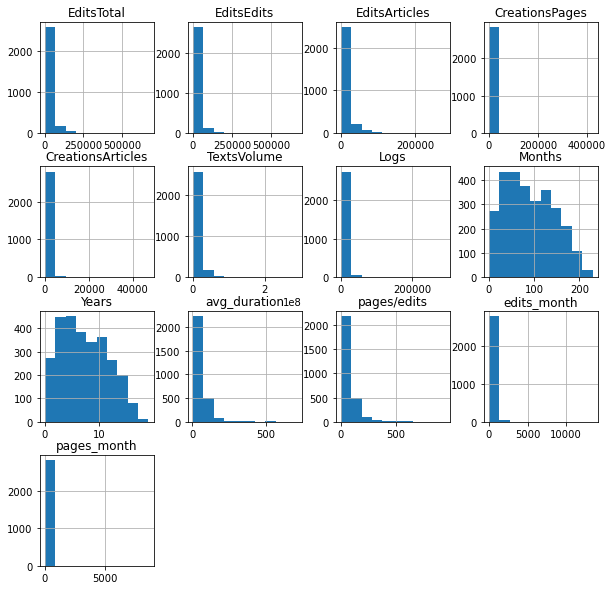

In [23]:
# Построим гистограммы для числовых значений
df_users.hist(figsize=(10, 10));

In [24]:
# Изучим распределение числовых данных
df_users.describe()

,EditsTotal,EditsEdits,EditsArticles,CreationsPages,CreationsArticles,TextsVolume,Logs,Months,Years,avg_duration,pages/edits,edits_month,pages_month
count,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2.828000e+03,2828.000000,2828.000000,2828.000000,2828.000000,2827.000000,2828.000000,2828.000000
mean,25260.686351,20305.707921,14264.883663,1608.497525,445.894979,1.075621e+07,4955.039250,91.859972,7.203678,55.178571,65.335296,241.585045,19.604281
std,41604.763551,32712.980284,23723.758702,8682.663965,1582.146157,1.820442e+07,14048.316926,53.261495,4.447337,41.758883,67.982394,399.216450,166.482660
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000
25%,6389.750000,5687.250000,3767.250000,156.000000,29.000000,2.300000e+06,251.250000,46.000000,3.000000,30.000000,21.667100,76.184992,2.270913
50%,11238.500000,9608.000000,6478.500000,471.000000,103.000000,4.900000e+06,1011.000000,86.000000,7.000000,45.000000,46.198389,137.390398,6.422498
75%,24941.250000,20983.500000,14360.750000,1316.500000,329.000000,1.100000e+07,3642.750000,134.000000,11.000000,65.000000,87.896623,274.541746,15.874562
max,670625.000000,658747.000000,277881.000000,423066.000000,47062.000000,2.880000e+08,290315.000000,229.000000,19.000000,705.000000,946.923744,13443.816327,8634.000000


In [25]:
# Для каждого пользователя добавим информацию о его участии в голосованиях
voters = df_votes.pivot_table(index='voter', columns='n', values='vote', aggfunc='count').reset_index()
voters[[30,31,32,33,34,35]] = voters[[30,31,32,33,34,35]]>=0
df_users = df_users.merge(voters.set_index('voter'), left_on='User', right_on='voter', how='left')

# Заполним пропуски значением False
df_users[[30,31,32,33,34,35]] = df_users[[30,31,32,33,34,35]].fillna(False)

In [26]:
# Добавим столбец с долей принятых правок в общем кол-ве правок, внесенных пользователем
df_users['EditsAccepted'] = df_users['EditsEdits']/df_users['EditsTotal']

In [27]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2828 entries, 0 to 2827
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   User               2828 non-null   object 
 1   Groups             2828 non-null   object 
 2   EditsTotal         2828 non-null   int64  
 3   EditsEdits         2828 non-null   int64  
 4   EditsArticles      2828 non-null   int64  
 5   CreationsPages     2828 non-null   int64  
 6   CreationsArticles  2828 non-null   int64  
 7   TextsVolume        2828 non-null   int64  
 8   Logs               2828 non-null   int64  
 9   Months             2828 non-null   int64  
 10  H/d                2828 non-null   object 
 11  Years              2828 non-null   int32  
 12  avg_duration       2828 non-null   int64  
 13  pages/edits        2827 non-null   float64
 14  edits_month        2828 non-null   float64
 15  pages_month        2828 non-null   float64
 16  30                 2828 

**Мы добавили в датафрейм следующие столбцы:**
- years - длительность участия в проекте в годах, где 0 - пользователь зарегистрирован менее года назад
- avg_duration - среднее время активности в день в минутах
- pages/edit - количество созданных пользователем новых страниц на 1000 правок
- edits_month - среднее количество вносимых правок в месяц
- pages_month - среднее количество создаваемых страниц в месяц
- Столбцы 30,31,32,33,34,35 - участие пользователя в соответствующих выборах (True или False)
- EditsAccepted - доля принятых правок в общем кол-ве правок, предложенных пользователем

<a id="part4"></a>

## 4. Итоги выборов

In [28]:
# Построим таблицу с общей информацией по каждым выборам
elections_info = df_votes.pivot_table(index='n', values = ['time', 'candidate','voter'], aggfunc = {'time':['min', 'max'], 'candidate':'nunique','voter':['nunique','count']})
elections_info.columns = ['Кол-во кандидатов', 'Окончание выборов', 'Начало выборов', 'Кол-во голосов всего', 'Кол-во избирателей']
elections_info = elections_info[['Начало выборов', 'Окончание выборов','Кол-во кандидатов', 'Кол-во избирателей', 'Кол-во голосов всего']]
elections_info['Среднее кол-во голосов на кандидата'] = (elections_info['Кол-во голосов всего']/elections_info['Кол-во кандидатов']).round(0)
elections_info['За сколько кандидатов голосует 1 пользователь'] = (elections_info['Кол-во голосов всего']/elections_info['Кол-во избирателей']).round(0)
elections_info['За какой процент кандидатов голосует 1 пользователь, %'] = ((elections_info['За сколько кандидатов голосует 1 пользователь']/elections_info['Кол-во кандидатов'])*100).round(1)
elections_info[['Начало выборов','Окончание выборов']] = elections_info[['Начало выборов','Окончание выборов']].apply(lambda x: x.dt.date)
elections_info

,Начало выборов,Окончание выборов,Кол-во кандидатов,Кол-во избирателей,Кол-во голосов всего,Среднее кол-во голосов на кандидата,За сколько кандидатов голосует 1 пользователь,"За какой процент кандидатов голосует 1 пользователь, %"
n,,,,,,,,
30,2020-07-30,2020-08-05,14,230,1879,134.0,8.0,57.1
31,2021-01-30,2021-02-05,13,239,1750,135.0,7.0,53.8
32,2021-07-30,2021-08-05,28,275,4094,146.0,15.0,53.6
33,2022-01-30,2022-02-05,17,331,3283,193.0,10.0,58.8
34,2022-07-30,2022-08-05,15,320,3123,208.0,10.0,66.7
35,2023-01-30,2023-02-05,11,238,1847,168.0,8.0,72.7


**Выводы:**\
Выборы проводятся каждые полгода.\
При этом в 32 выборах участвовало наибольшее кол-во кандидатов - 28 человек.\
По кол-ву избирателей самые активные выборы - 33 и 34, в них участвовало более 320 избирателей.\
В 2020-2021 году каждый кандидат получал 134-135 голосов, в 33-34 выборах при росте кол-ва избирателей кол-во голосов выросло.\
**На 30-33 выборах 1 пользователь в среднем голосовал за 50-60% кандидатов, а в остальных случаях воздерживался. В 35 выборах участвовало всего 11 кандидатов, при этом 1 пользователь в среднем проголосовал за 8х.**

In [29]:
# Подведем итоги каждых выборов

# Подсчитаем кол-во голосов за каждого участника
elections_result = df_votes.pivot_table(index= ['n','candidate'], columns='vote', values='voter', aggfunc='count')
elections_result.columns = ['vote_against', 'vote_for']
elections_result['total'] = (elections_result['vote_for'] + elections_result['vote_against']).round(1)
elections_result['vote_for_%'] = (elections_result['vote_for']/elections_result['total']*100).round(1)

# Разделим кандидатов на победителей и програвших
elections_result['result'] = (
                              pd.cut(elections_result['vote_for_%'], bins=[0, 2/3*100, 100], labels=['Проиграл', 'Победил'])
                                .astype('str')
)

In [30]:
# Изучим список победителей каждого этапа выборов
elections_result.query('result == "Победил"').head(100)

vote_against  vote_for  total  vote_for_%   result
n  candidate                                                               
30 Adamant.pwn                     43        93    136        68.4  Победил
   AndyVolykhov                    41       120    161        74.5  Победил
   Carn                            43       116    159        73.0  Победил
   Colt browning                   34        84    118        71.2  Победил
   Lesless                         17       162    179        90.5  Победил
   SerSem                          34        97    131        74.0  Победил
   Юрий Владимирович Л.             8       152    160        95.0  Победил
31 Ouaf-ouaf2010                   30        93    123        75.6  Победил
   Sir Shurf                       30       147    177        83.1  Победил
   Vyacheslav Bukharov             26        98    124        79.0  Победил
   Джекалоп                        22       158    180        87.8  Победил
   Кронас                          41        96    137        70.1  Победил
   Сайга20К                        10       155    165        93.9  Победил
   Юлия 70                         18       144    162        88.9  Победил
32 Bapak Alex                      44       136    180        75.6  Победил
   Biathlon                        55       126    181        69.6  Победил
   Butko                           64       131    195        67.2  Победил
   Deltahead                       33       138    171        80.7  Победил
   Venzz                           51       110    161        68.3  Победил
   Ле Лой                          30       194    224        86.6  Победил
   Юлия 70                         60       140    200        70.0  Победил
33 Biathlon                        73       160    233        68.7  Победил
   Carn                            56       183    239        76.6  Победил
   Draa kul                        24       200    224        89.3  Победил
   El-chupanebrej                  41       203    244        83.2  Победил
   Oleg Yunakov                    41       160    201        79.6  Победил
   Всеслав Чародей                 65       135    200        67.5  Победил
34 Carn                            79       160    239        66.9  Победил
   Deinocheirus                    37       204    241        84.6  Победил
   Excellence                      39       151    190        79.5  Победил
   Khinkali                        68       137    205        66.8  Победил
   Tatewaki                        31       169    200        84.5  Победил
   Ле Лой                          50       222    272        81.6  Победил
35 Adamant.pwn                     60       128    188        68.1  Победил
   Colt browning                   32       147    179        82.1  Победил
   Draa kul                        32       154    186        82.8  Победил
   Excellence                      48       129    177        72.9  Победил

**По итогам каждых выборов необходимый порог для победы проходит 6-7 человек.\
Исключение - 35 выборы, где нужную отметку прошло только 4 кандидата из 11 (при этом в 35 выборах участвовало минимальное кол-во кандидатов по сравнению с другими выборами).**

Рассмотрим, какие кандидаты принимали участие в нескольких выборах и как менялись их результаты. 

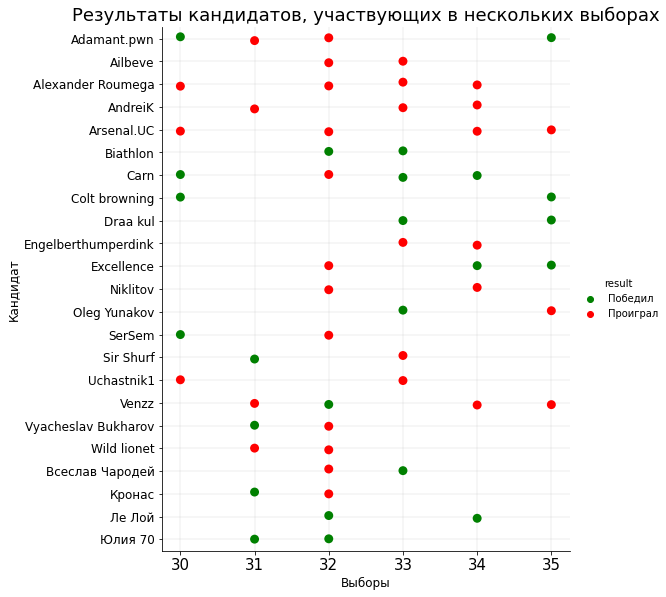

In [31]:
# Изучим результаты кандидатов, которые участвовали в нескольких выборах
elections_result = elections_result.reset_index()
many_times = (
             elections_result[elections_result.duplicated(subset = 'candidate', keep=False)]
                             .sort_values(by=['candidate','n']).reset_index(drop=True)
)

# Построим визуализацию и сравним результаты кандидата на каждых выборах
(
    sns.catplot(data = many_times, x = 'n', y = 'candidate', hue = 'result',  
                kind = 'strip', s= 80, height=8, aspect=1, palette={"Победил": "g", "Проиграл": "r"})
)

plt.title('Результаты кандидатов, участвующих в нескольких выборах', fontsize=18)
plt.ylabel('Кандидат', fontsize=12)
plt.xlabel('Выборы', fontsize=12)
plt.xticks(fontsize = 15, rotation=0)
plt.yticks(fontsize = 12)
plt.grid(linewidth=0.2)
sns.despine();

**23 кандидата из 63 участвовали в нескольких выборах (максимальное значение - 4 голосования).** Часто результат таких кандидатов одинаков.\
Однако, для 10 кандидатов результаты выборов отличаются: Adamant.pwn(2 победы из 4х выборов), Carn (2 из 3), Excellence(2 из 4), Oleg Yunakov(1 из 2), SerSem(1 из 2), Sir Shurf(1 из 2), Venzz(1 из 4), Vyacheslav Bukharov(1 из 2), Всеслав Чародей(1 из 2), Кронас(1 из 2).


In [32]:
# Добавим данные о результатах выборов в исходный датафрейм
df_votes = df_votes.merge(elections_result[['n','candidate','result']], on=['n', 'candidate'], how='left')

In [33]:
# На основании результата голосования, разделим голоса на типы "за победителя"/"против победителя"
conditions = [
    (df_votes['vote'] == 1) & (df_votes['result'] == 'Победил'),
    (df_votes['vote'] == -1) & (df_votes['result'] == 'Победил'),
    (df_votes['vote'] == 1) & (df_votes['result'] == 'Проиграл'),
    (df_votes['vote'] == -1) & (df_votes['result'] == 'Проиграл'),
]

values = ['Голос за победителя', 'Голос против победителя', 'Голос за проигравшего', 'Голос против проигравшего']

df_votes['vote_result'] = np.select(conditions, values)

In [34]:
# Рассчитаем процент угадывания результатов выборов каждым избирателем
goal_achievement = df_votes.pivot_table(index='voter', columns = 'vote_result', values = 'vote', aggfunc = 'count').fillna(0).reset_index()
goal_achievement['Всего голосов'] = np.sum(goal_achievement,axis=1)
goal_achievement['Цель достигнута'] = goal_achievement['Голос за победителя'] + goal_achievement['Голос против проигравшего']
goal_achievement['supporter_share'] = (goal_achievement['Цель достигнута']/goal_achievement['Всего голосов']).round(2)

# Добавим этот столбец в датафрейм
df_votes = df_votes.merge(goal_achievement[['voter','supporter_share']], on='voter', how='left')

In [35]:
# Добавим в датафрейм данные о том, на сколько часто кандидат является сторонником
supporter = df_votes.pivot_table(index='voter', values='supporter_share')
df_users = df_users.merge(supporter['supporter_share'], left_on='User', right_on='voter', how='left')

In [36]:
# Разделим пользователей на сторонников и оппозиционеров
df_users['support'] = (
                       pd.cut(df_users['supporter_share'], bins=[0, 0.3, 0.7, 1.0], 
                             labels=['Оппозиционер', 'Нет позиции', 'Сторонник'], include_lowest=True) 
)

In [37]:
# Рассчитаем долю конформизма каждого пользователя (насколько часто он голосует "за", а не "против")
goal_achievement['Всего за'] = goal_achievement['Голос за победителя'] + goal_achievement['Голос за проигравшего']
goal_achievement['сonfzm_share'] = (goal_achievement['Всего за']/goal_achievement['Всего голосов']).round(2)

# Добавим этот столбец в датафрейм
df_votes = df_votes.merge(goal_achievement[['voter','сonfzm_share']], on='voter', how='left')

In [38]:
# Добавим в датафрейм данные о том, на сколько часто кандидат является конформистом
comformizm = df_votes.pivot_table(index='voter', values='сonfzm_share')
df_users = df_users.merge(comformizm['сonfzm_share'], left_on='User', right_on='voter', how='left')

In [39]:
# Разделим пользователей на конформистов и оппозиционеров
df_users['conformizm'] = (
                       pd.cut(df_users['сonfzm_share'], bins=[0, 0.3, 0.7, 1.0], 
                             labels=['Опортунист', 'Нет позиции', 'Конформист'], include_lowest=True) 
)

**Мы добавили в датафреймы еще 2 новых столбца:**
1. Доля согласия(поле support) с результатами выборов (доля голосов "За победителя" и "Против проигравшего"). А также провели сегментацию по этому полю  на "Сторонник", "Оппозиционер" и "Нет позиции".
2. Доля конформизма пользователя (поле сonfzm_share) - доля голосов "За" в общем количестве голосов. И также провели сегментаци по этому полю на "Конформист", "Оппортунист" и "Нет позиции".

<a id="part5"></a>

## 5. Результаты выборов по дням голосования

Проанализируем, на какой день выборов обычно голосуют пользователи, и есть ли какая-либо зависимость между результатами и днем голосования. 

In [40]:
# Напишем функцию, рассчитывающую день голосования
def day_of_elections(df):
    date_of_elections = df_votes.pivot_table(index='n', values='time', aggfunc='min').reset_index()
    election =  df['n']
    start_election = date_of_elections.query('n == @election')
    start_election = start_election['time'].min()
    day_of_elections = df['time'] - start_election
    return day_of_elections

# Добавим в датафрейм столбец с номером дня, на который голосовал пользователь
df_votes['day_of_elections'] = df_votes.apply(day_of_elections, axis=1)
df_votes['day_of_elections'] = df_votes['day_of_elections'].dt.days

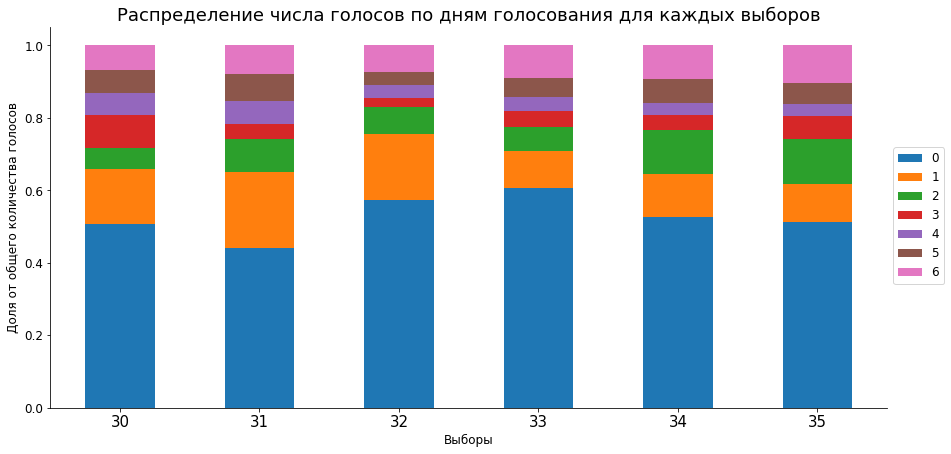

In [41]:
# Посмотрим распределение пользователей по дням голосования
day_elections = df_votes.pivot_table(index='day_of_elections', columns = 'n', values='voter', aggfunc='count')
day_elections = day_elections/day_elections.sum()

# Построим столбчатую диаграмму по результатам анализа
day_elections.T.plot.bar(stacked=True, figsize = (15,7))
plt.title('Распределение числа голосов по дням голосования для каждых выборов', fontsize=18)
plt.ylabel('Доля от общего количества голосов', fontsize=12)
plt.xlabel('Выборы', fontsize=12)
plt.xticks(fontsize = 15, rotation=0)
plt.yticks(fontsize = 12)
plt.legend(bbox_to_anchor=(1.0, 0.7), loc='upper left', fontsize=12)
sns.despine();

**Практически половина всех избирателей голосует в первый же день выборов. В 31 выборах активное голосование также происходило на 2ой день голосования. В последний день пользователи также активизируются и активность в голосовании на уровне 2го дня.**\
Можем предположить, что уже по итогам 1го дня результаты выборов известны к концу голосования практически не меняются. 

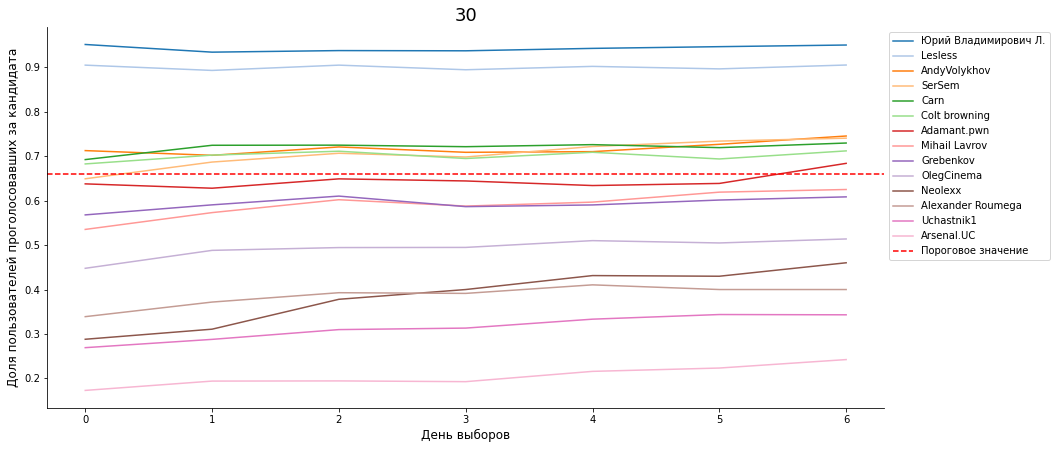

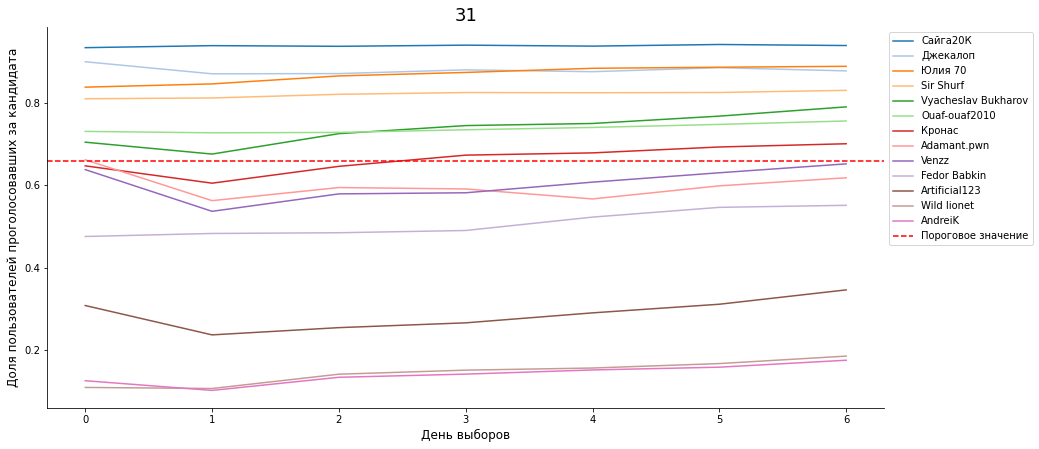

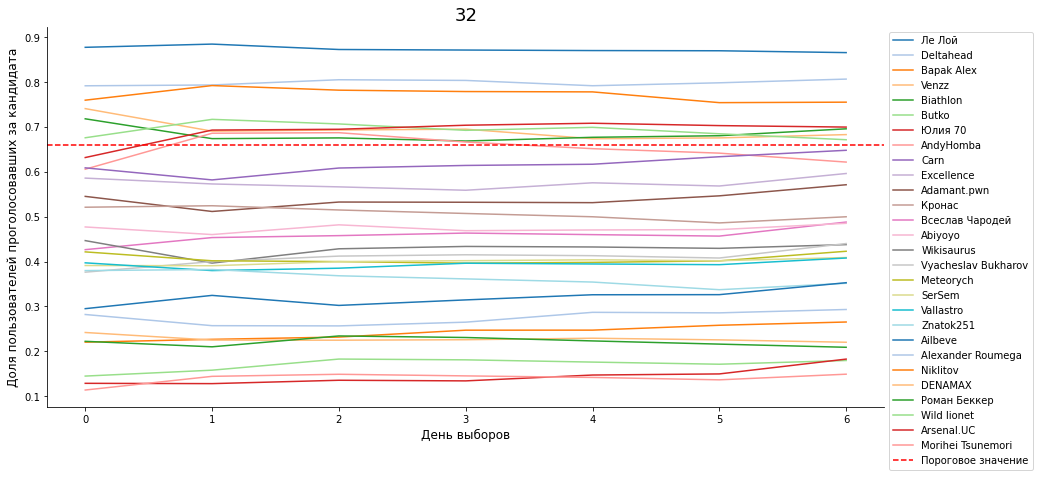

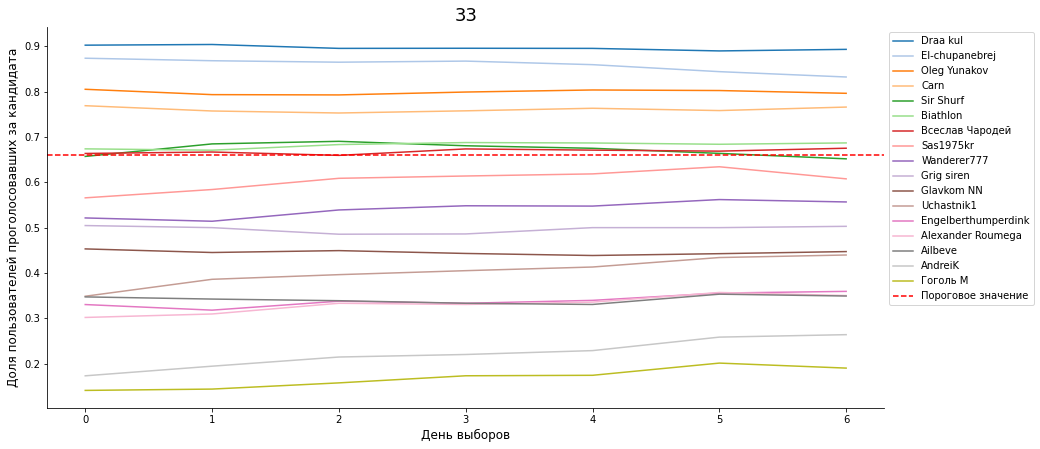

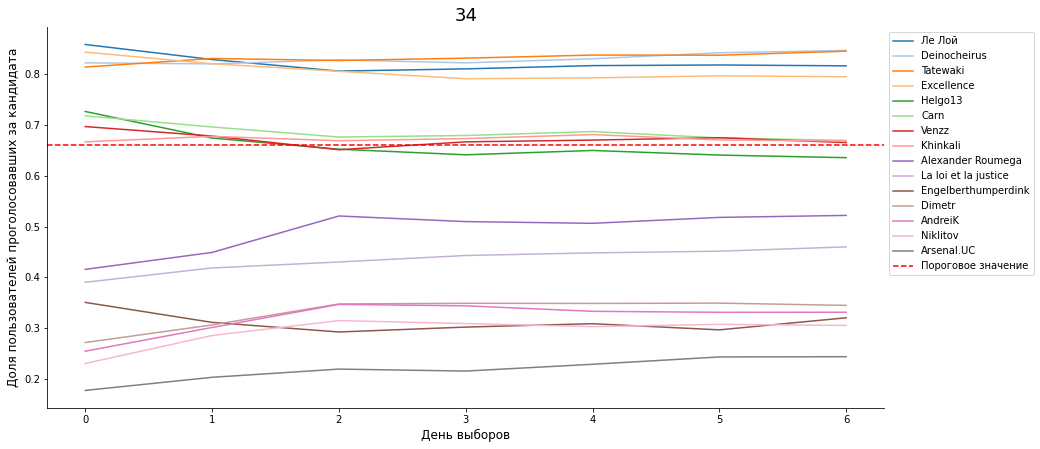

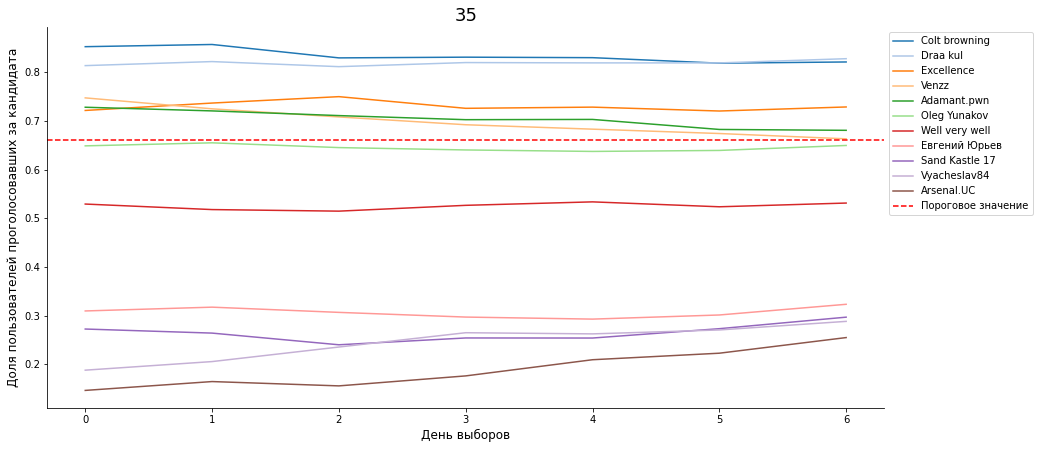

In [42]:
# Посчитаем данные для таймлайна
df_votes = df_votes.sort_values(by='day_of_elections')
timeline = df_votes.pivot_table(index= ['n','candidate','day_of_elections'], columns='vote', values='voter', aggfunc='count').fillna(0)
timeline.columns = ['Против', 'За']
timeline = timeline.reset_index()
timeline['Накопительно за'] = timeline.groupby(['n','candidate'])['За'].cumsum()
timeline['Всего голосов'] = timeline['За'] + timeline['Против']
timeline['Всего накопительно'] = timeline.groupby(['n','candidate'])['Всего голосов'].cumsum()
timeline['Доля За накопительно'] = timeline['Накопительно за']/timeline['Всего накопительно']
timeline = timeline.sort_values(['n','Доля За накопительно'], ascending = [True, False])

# Построим таймлайн с долей голосов для каждых выборов
for value in timeline['n'].unique():
    df = timeline.query('n == @value')
    plt.figure(figsize=(15,7))
    sns.lineplot(data=df, x='day_of_elections', y='Доля За накопительно', hue='candidate', palette = 'tab20')
    plt.axhline(y=0.66, color='red', linestyle='--', label='Пороговое значение')
    plt.title(value, fontsize=18)
    plt.ylabel('Доля пользователей проголосовавших за кандидата', fontsize=12)
    plt.xlabel('День выборов', fontsize=12)
    sns.despine()
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=10)
    plt.show();

**Действительно, 1ый день голосования практически в каждом случае определелял итоги всех выборов и к концу голосования результат практически не меняется.**\
**Также мы видим, что в целом есть тенденция к увеличению процента у явно проигравших в первый день.\
Тем не менее, в каждых выборах (кроме 35) есть кандидат, результат которого по итогам дня был близок к пороговому значению, но кардинально менялся во 2ой-7ой день голосования.** Изучим этих кандидатов. 

In [43]:
# Рассчитаем, на сколько результат по итогам 1го дня голосования отличается от финального
day_1 = timeline.query('day_of_elections == 1').pivot_table(index=['n', 'candidate'], values = 'Доля За накопительно').reset_index()
day_1.columns = ['n', 'candidate', 'result_1']
day_1['result_1'] = (day_1['result_1']*100).round(1)
finish_result = day_1.merge(elections_result[['n','candidate','vote_for_%']], on = ['n', 'candidate'], how='left')
finish_result.columns = ['n', 'candidate', 'result_1','result_7']
finish_result['diff'] = finish_result['result_7'] - finish_result['result_1']
finish_result.query('(result_1>66 and result_7<66) or (result_1<66 and result_7>66)')

,n,candidate,result_1,result_7,diff
0,30,Adamant.pwn,62.8,68.4,5.6
24,31,Кронас,60.5,70.1,9.6
31,32,AndyHomba,68.6,62.2,-6.4
67,33,Sir Shurf,68.5,65.2,-3.3
80,34,Helgo13,67.4,63.6,-3.8


In [44]:
# На сколько финальный результат отличается от 1го дня в среднем
finish_result['diff'].mean()

2.304081632653061

**В среднем окончательный результат голосования отличается от результатов 1го дня всего на 2,3%.\
При этом для 5 кандидатов разница результатов 1го дня голосования и 7го стала решающей.**
Adamant.pwn(30 выборы) и Кронас(31 выборы) по итогам 1го дня голосования не набирали необходимого количества голосов "За" для победы, однако в процессе голосования донабрали необходимое кол-во и прошли.\
AndyHomba(32 выборы), Sir Shurf(33 выборы), Helgo13(34 выборы) напротив, по итогам 1го дня побеждали, однако в результате доля голосов "За" оказалась ниже порогового значения. 
Но стоит отметить, что даже после 1го дня голосования результаты этих кандидатов были близки к пороговым значениям, т.е. кардинального изменения хода выборов нет. 

<a id="extra1"></a>

In [45]:
# Рассмотрим распределение типов голосов по дням голосования (об общего кол-ва)
day_type = df_votes.pivot_table(index='day_of_elections', columns=['result','vote_result'], values='vote', aggfunc='count')
day_type = (day_type*100/len(df_votes)).round(2)
day_type

result                       Победил                          \
vote_result      Голос за победителя Голос против победителя   
day_of_elections                                               
0                              17.40                    4.97   
1                               4.89                    1.46   
2                               2.90                    0.85   
3                               1.70                    0.48   
4                               1.61                    0.36   
5                               1.83                    0.63   
6                               3.03                    0.70   

result                        Проиграл                            
vote_result      Голос за проигравшего Голос против проигравшего  
day_of_elections                                                  
0                                12.69                     19.05  
1                                 3.39                      4.72  
2                                 2.54                      2.40  
3                                 1.10                      1.34  
4                                 1.13                      1.03  
5                                 1.60                      1.47  
6                                 2.55                      2.17

Анализируя результаты проигравшего кандидата, мы видим, что в 1ый и 2ой день голосования избиратели активнее голосуют "Против" кандидата. Однако, в последние дни голосования ситуация меняется - кол-во голосов "За" становится немного выше, чем "Против", т.е. кандидата стараются "вытянуть".

Также можно отметить общую разницу в голосовании 2го и последнего дня. Активность голосования в последний день практически на уровне 2го дня. Однако, количество голосов "За" (как за победителя, так и за проигравшего) в последний день даже выше, чем во 2ой день. Кол-во голосов "Против" (как против победителя, так и против проигравшего) в последний день, напротив, ниже по сравнению со 2ым. 

In [46]:
# Дополнительно также расмотрим распределение типа голоса по дням голосования (от кол-ва по типу голоса)
day_type_2 = df_votes.pivot_table(index='day_of_elections', columns=['result','vote_result'], values='vote', aggfunc='count')
day_type_2 = (day_type_2*100/day_type_2.sum()).round(2)
day_type_2

result                       Победил                          \
vote_result      Голос за победителя Голос против победителя   
day_of_elections                                               
0                              52.14                   52.58   
1                              14.67                   15.50   
2                               8.70                    8.94   
3                               5.08                    5.03   
4                               4.84                    3.84   
5                               5.50                    6.69   
6                               9.08                    7.42   

result                        Проиграл                            
vote_result      Голос за проигравшего Голос против проигравшего  
day_of_elections                                                  
0                                50.78                     59.20  
1                                13.58                     14.66  
2                                10.15                      7.45  
3                                 4.38                      4.16  
4                                 4.53                      3.21  
5                                 6.39                      4.57  
6                                10.20                      6.75

Помимо выводов, сделанных выше, мы можем увидеть, что в последний день голосования проходит практически 10% от всех голосов "За" и только 7% от кол-ва голосов Против. 

<a id="part6"></a>

## 6. Количество набранных голосов для победы

Ранее мы рассчитали, что на каждых выборах в среднем кандидат набирает 134-208 голосов. Посмотрим, равномерно ли это распределение по кандидатам и есть ли какая-то зависимость между количество набранных голосов и результатом голосования. 

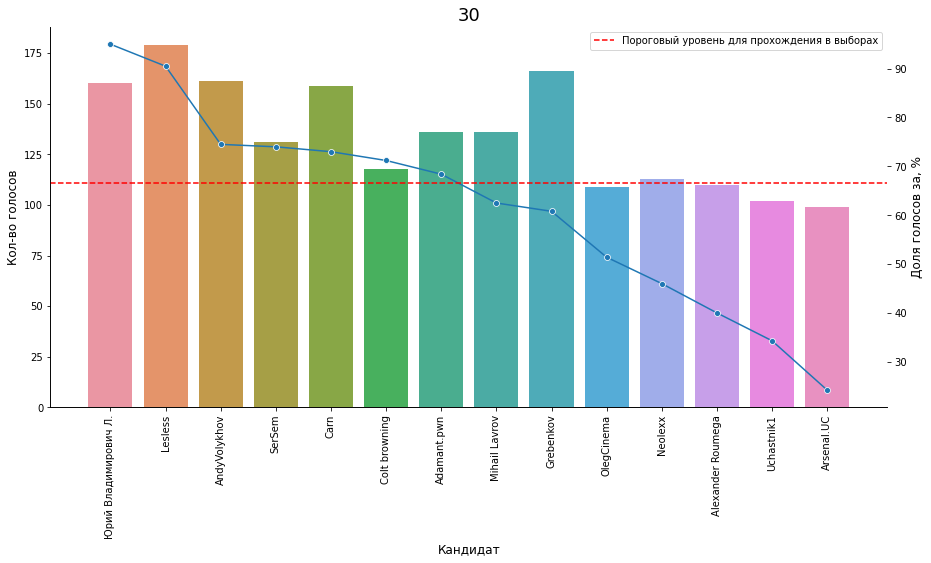

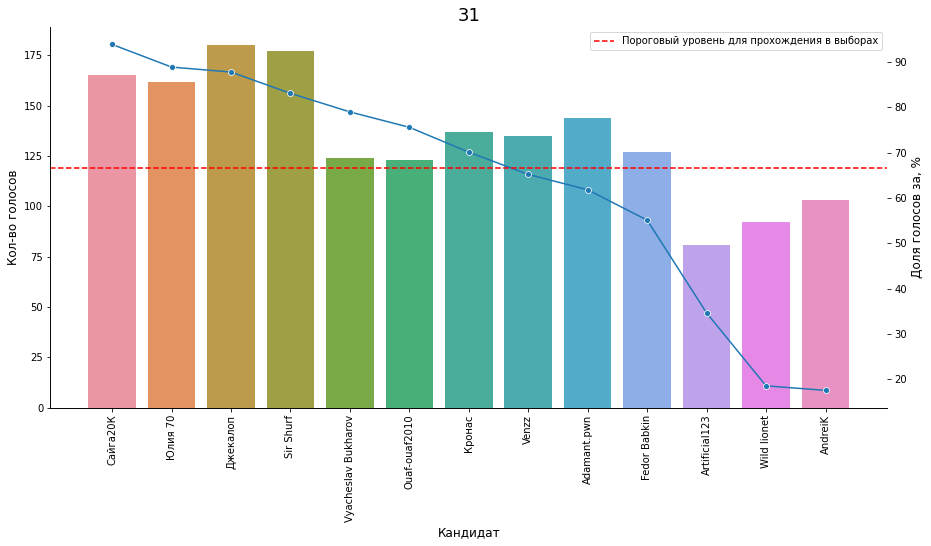

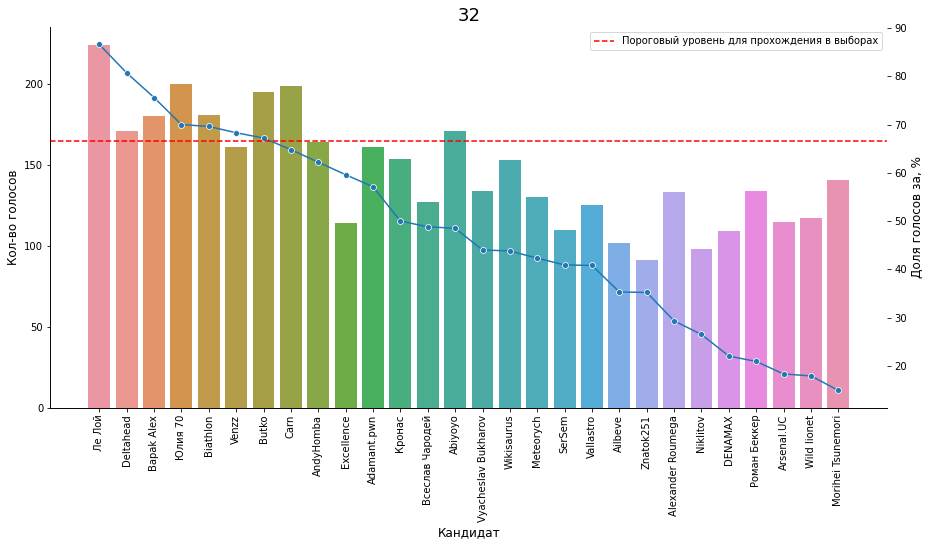

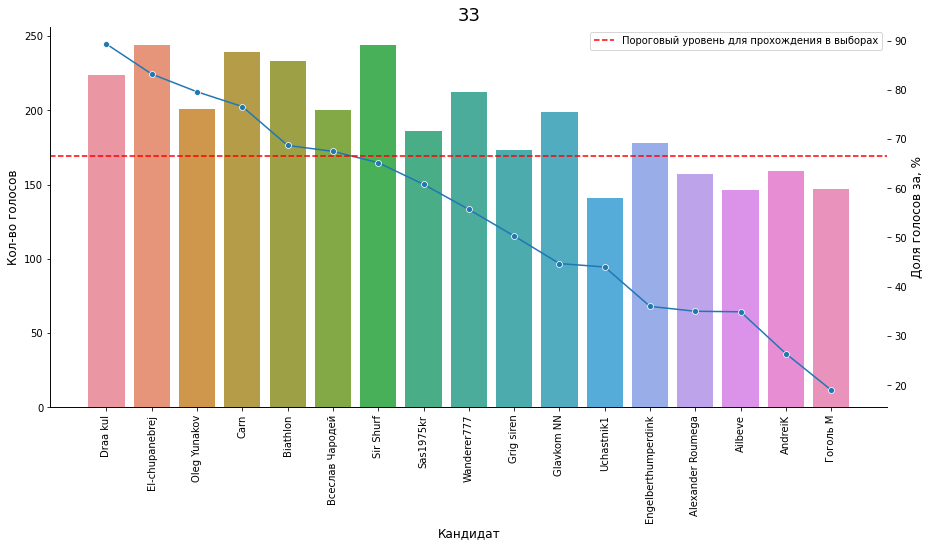

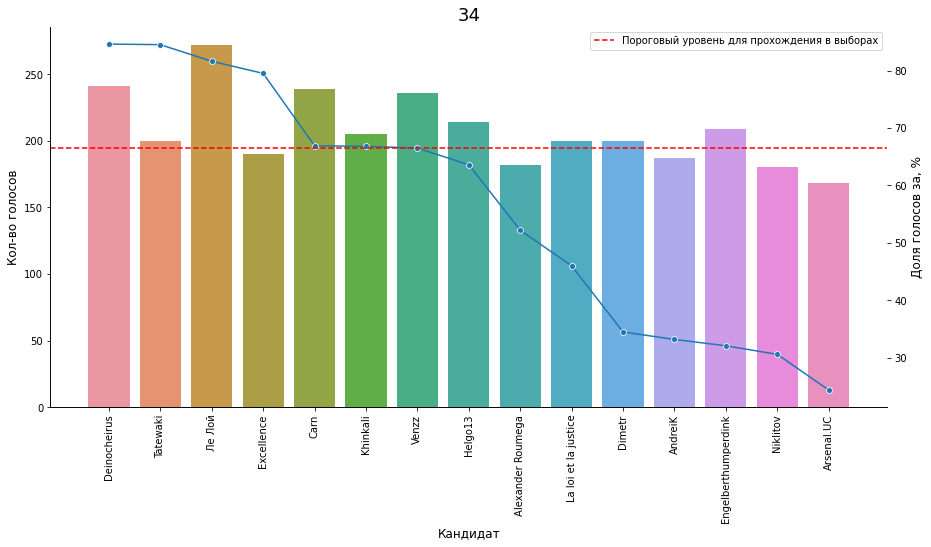

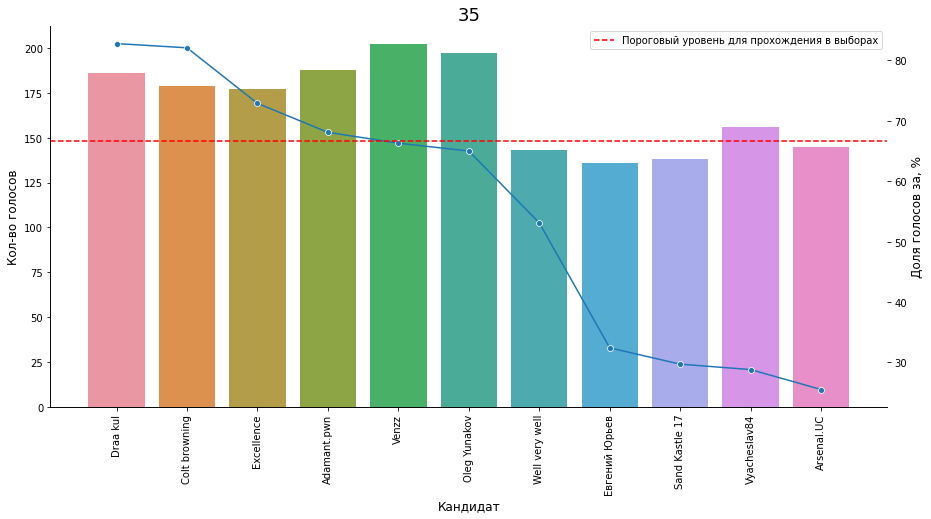

In [47]:
for value in elections_result['n'].unique():
    df = elections_result.query('n == @value').sort_values(by='vote_for_%', ascending = False)
    ax1 = sns.set_style(style=None, rc=None )
    fig, ax1 = plt.subplots(figsize=(15,7))
    sns.barplot(data=df, x='candidate', y='total', ax=ax1)
    plt.xticks(rotation = 90, fontsize=10)
    plt.ylabel('Кол-во голосов', fontsize=12)
    plt.xlabel('Кандидат', fontsize=12)
    ax2 = ax1.twinx()
    sns.lineplot(data = df, x='candidate', y='vote_for_%', marker='o', ax=ax2)
    plt.ylabel('Доля голосов за, %', fontsize=12)
    plt.axhline(y=66.6, color='red', linestyle='--', label='Пороговый уровень для прохождения в выборах')
    plt.legend()
    plt.title(value, fontsize=18)
    sns.despine()
    plt.show();

В целом, мы видим, что **победители набирают больше голосов, чем проигравшие. Т.е. люди более активно голосуют за тех, кого хотят видеть, чем против кого-то.**\
Также важно отметить прирост кол-ва голосов в местах пересения линий порогового значения и доли голосов "за", это говорит о том, что за кандидатов, чьи результаты близки к пороговым значениям (60-70%) также голосование проходит более активно и ведется борьба. 

In [48]:
# Рассчитаем кол-во голосов на 1 кандидата в зависимости от результата
vote_qnt = df_votes.pivot_table(index=['n','result'], values=['candidate','vote'], aggfunc={'candidate':'nunique','vote':'count'})
vote_qnt['vote_1candidate'] = (vote_qnt['vote']/vote_qnt['candidate']).astype('int')
vote_qnt.columns = ['Кол-во кандидатов', 'Кол-во голосов', 'Кол-во голосов на 1 кандидата']
vote_qnt

Кол-во кандидатов  Кол-во голосов  Кол-во голосов на 1 кандидата
n  result                                                                    
30 Победил                   7            1044                            149
   Проиграл                  7             835                            119
31 Победил                   7            1068                            152
   Проиграл                  6             682                            113
32 Победил                   7            1312                            187
   Проиграл                 21            2782                            132
33 Победил                   6            1341                            223
   Проиграл                 11            1942                            176
34 Победил                   6            1347                            224
   Проиграл                  9            1776                            197
35 Победил                   4             730                            182
   Проиграл                  7            1117                            159

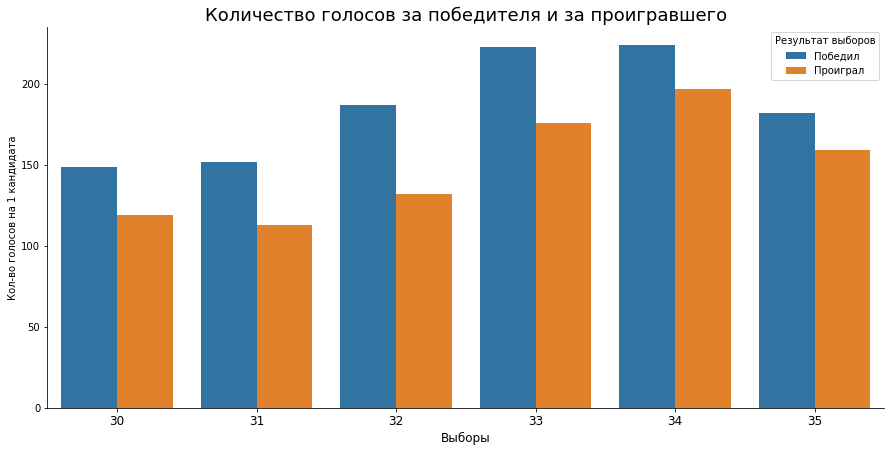

In [49]:
# Визуализируем данные в таблице
vote_qnt = vote_qnt.reset_index()
plt.figure(figsize=(15,7))
sns.barplot(data=vote_qnt, x='n', y='Кол-во голосов на 1 кандидата', hue='result')
plt.title('Количество голосов за победителя и за проигравшего', fontsize=18)
plt.xticks(fontsize = 12)
plt.xlabel('Выборы', fontsize=12)
plt.legend(title='Результат выборов')
sns.despine();

Действительно, **победители набирают на 23-55 (в зависимости от выборов) больше голосов, чем проигравшие.**

<a id="part7"></a>

## 7. Консервативность избирателей

Проанализируем, насколько кандидаты оправдывают ожидания пользователей и как голосуют пользователи при выдвижении кандидата повторно(отличается ли голос пользователя на следующих выборах или нет).

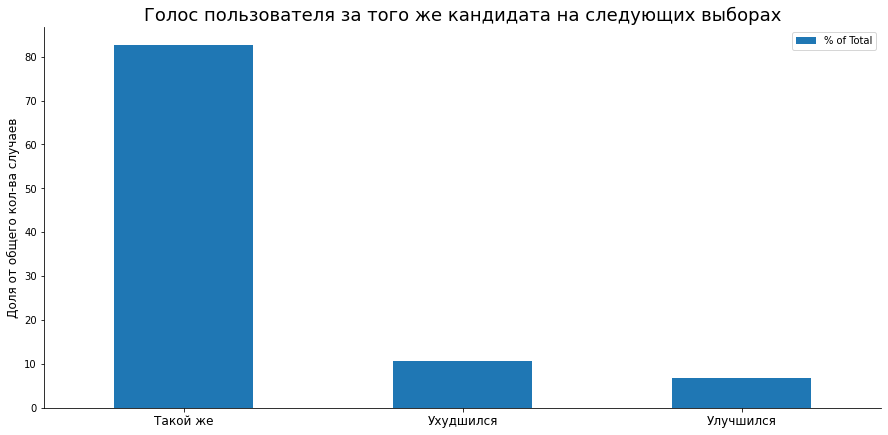

In [50]:
# Отберем случаи, когда избиратель голосовал за одного и того же кандидата (на разных выборах), отсортируем их и добавим столбец с голосом на прошлом голосовании
past_elections = (
                  df_votes[df_votes.duplicated(subset=['voter','candidate'],keep=False)]
                       .sort_values(by=['voter','candidate','n']).reset_index(drop=True)
)

past_elections = past_elections[['voter','candidate','n','vote']]
past_elections['past_vote'] = past_elections.groupby(['voter','candidate'])['vote'].shift(1)
past_elections = past_elections.dropna(subset='past_vote')

# Напишем функцию, сравнивающие голос с голосом прошлого голосования
def past_vote(df):
        if df['vote'] == df['past_vote']: return "Такой же"
        if df['vote'] > df['past_vote']: return "Улучшился"
        else: return "Ухудшился"

# Применим функцию
past_elections['past_vote_type'] = past_elections.apply(past_vote, axis=1)

# Визуализируем результат
past_elections.pivot_table(index='past_vote_type', values='vote', aggfunc = 'count')\
              .assign(**{'% of Total': lambda x: x['vote'] / x['vote'].sum() * 100})\
              .sort_values(by='vote', ascending=False)\
              .plot(y='% of Total', kind='bar', figsize=(15,7))
plt.title('Голос пользователя за того же кандидата на следующих выборах', fontsize=18)
plt.xticks(rotation=0, fontsize = 12)
plt.ylabel('Доля от общего кол-ва случаев', fontsize=12)
plt.xlabel('')
sns.despine();

Мы видим, что **пользователи достаточно консервативны и в 80% сохраняют свой голос за кандидата на следующих выборах.**\
Но примечательно, при изменении голос чаще менялся в худшую сторону, т.е. бывают случаи, когда кандидат не оправдал ожидания пользователя. 

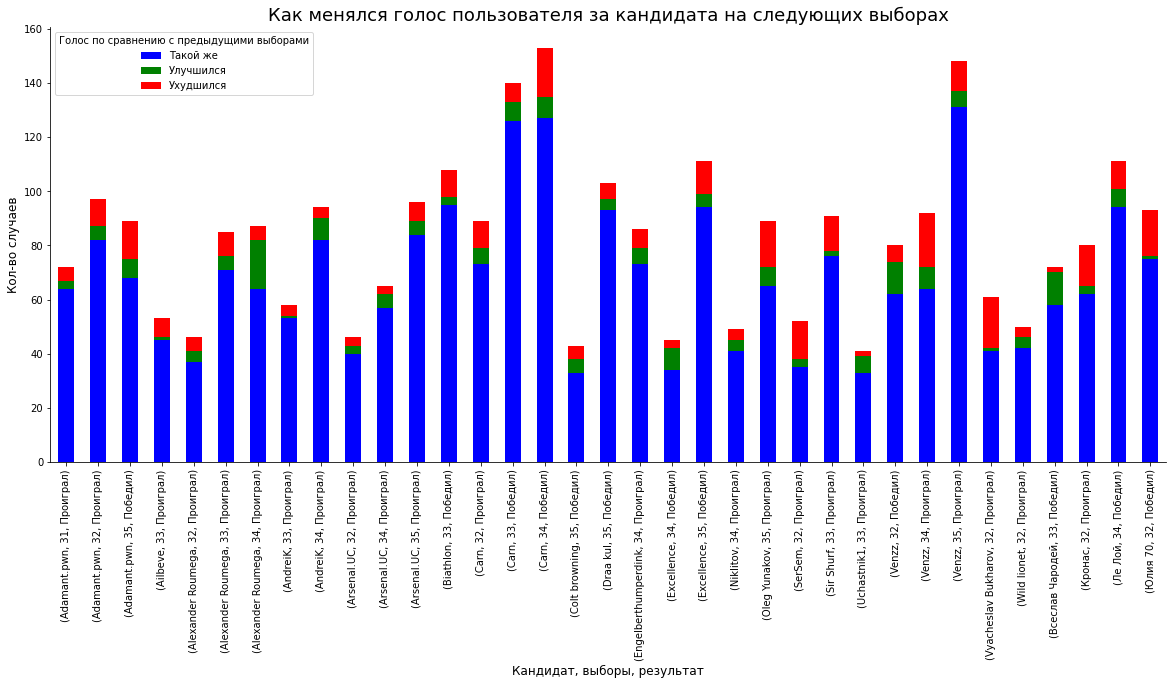

In [51]:
# Изучим данные в разрезе по кандидатам
past_elections = past_elections.merge(elections_result[['n','candidate','result']], on=['n', 'candidate'], how='left')
past_elections.pivot_table(index=['candidate','n','result'], columns = 'past_vote_type', values='vote', aggfunc = 'count')\
              .plot(kind='bar', stacked=True, figsize=(20,8), color=['blue','green','red'])
plt.title('Как менялся голос пользователя за кандидата на следующих выборах', fontsize=18)
plt.ylabel('Кол-во случаев', fontsize=12)
plt.xlabel('Кандидат, выборы, результат', fontsize=12)
plt.legend(title ='Голос по сравнению с предыдущими выборами')
sns.despine();

Зависимости между изменением голоса пользователя и результатами выборов нет.\
Alexandеr Roumega принимал участие в 31,32,33 и 34 выборах (все проиграны), при этом мы видим, что на последних 34 выборах соотношение голосов по нему сильно улучшилось, выросла доля пользователей, голосующих за.\
Активно участвует в выборах также кандидат Cam. При этом на 34 выборах, мы видим, что часть пользователей изменила свой голос в худушую сторону. 

<a id="part8"></a>

## 8. Кластерный анализ пользователей, участвующих в голосовании

Разделим пользователей, принимающих участие в выборах, на кластеры с помощью метода К-means и рассмотрим, как отдельные группы пользователей, а также изучим характеристики каждого кластера. 

Для каждого кандидата от каждого пользователя мы возьмем медианную оценку. Т.е. в случаях, если кандидат принимал участие в нескольких выборах и голос пользователя за этого кандидата менялся, это будет учтено в нашем анализе. 

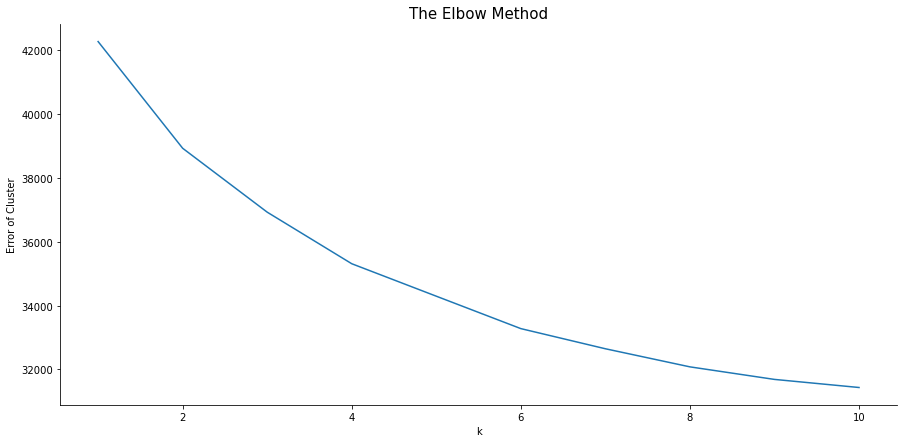

In [52]:
# Построим сводную таблицу с медианной оценкой избирателя каждому кандидату
data = df_votes.pivot_table(index='voter', columns ='candidate', values ='vote', aggfunc ='median').reset_index().fillna(0)
data_1 = data.iloc[:, 1:]
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(data_1)

# Расчет оптимального количества кластеров
errors = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df_scaled)
    errors.append(model.inertia_)
    
plt.figure(figsize=(15,7))    
plt.title('The Elbow Method', fontsize=15)
plt.xlabel('k')
plt.ylabel('Error of Cluster')
plt.plot(range(1,11),errors)
sns.despine()
plt.show()

Разделим пользователей на 6 кластеров.  

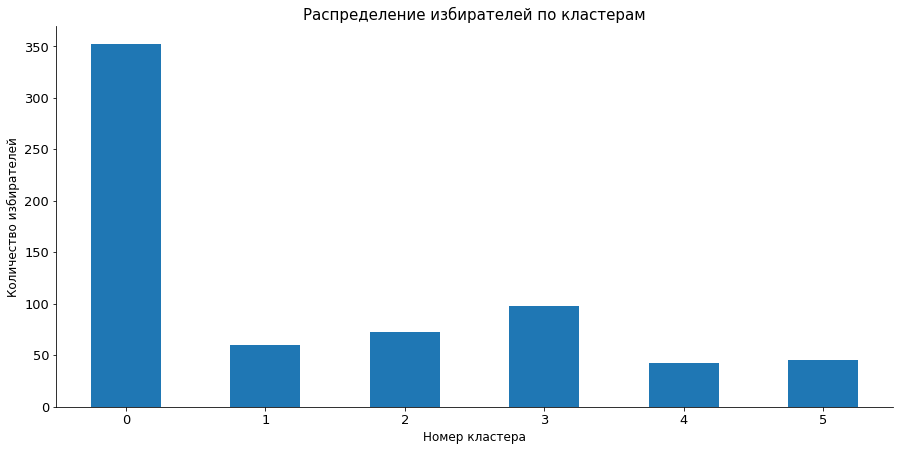

In [53]:
# Построим модель
model = KMeans(n_clusters = 6, random_state=42)
model.fit(df_scaled)
data_1 = data_1.assign(ClusterLabel = model.labels_)

# Добавим разделение на кластеры в исходную таблицу
data = data.merge(data_1, left_index=True, right_index=True)

# Посмотрим распределение кандидатов по кластерам
plt.figure(figsize=(15,7))   
data.groupby('ClusterLabel')['voter'].agg('count').plot(kind='bar')
plt.title('Распределение избирателей по кластерам', fontsize=15)
plt.ylabel('Количество избирателей', fontsize=12)
plt.xlabel('Номер кластера', fontsize=12)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(fontsize=13)
sns.despine();

In [54]:
# Добавим номер кластера в исходный датафрейм
df_votes = df_votes.merge(data[['voter', 'ClusterLabel']], on='voter', how='left')

Разделение пользователей на кластеры проведено, в исходный датафрейм мы также добавили номер кластера, к которому относится пользователь.\
Наибольше количество пользователей находится в кластере 0 - 352 человека. Еще 98 пользователей в кластере 3. Кластеры 1 и 2 содержат по 60-73 пользователей. Самые малочисленные получились кластеры 4 и 5 - всего 43-45 пользователей.\
Изучим особенности каждого кластера.


In [55]:
# Добавим в датафрейм с информацией по пользователям столбец с номером кластера пользователя
df_users = df_users.merge(data[['voter','ClusterLabel']].set_index('voter'), left_on='User', right_on='voter', how='left')

# Построим портрет пользователя для каждого кластера
cluster_stats = (
                   df_users.pivot_table(index='ClusterLabel', 
                                        values = ['EditsTotal','EditsEdits', 'EditsAccepted','CreationsPages',
                                                  'CreationsArticles', 'Months', 'Years', 'avg_duration', 'pages/edits', 
                                                  'edits_month','pages_month'], 
                                        aggfunc='median', margins=True)
)

cluster_stats.columns = (
                        ['Кол-во энциклопедических статей', 'Кол-во созданных страниц всего', 'Доля принятых правок', 
                         'Кол-во принятых правок', 'Кол-во предложенных правок', 'Участие в проекте, мес', 
                         'Участие в проекте, лет', 'Активное время в день', 'Кол-во правок в месяц', 
                         'Кол-во созданных страниц на 1000 правок', 'Кол-во страниц в месяц']
)

cluster_stats.style.highlight_max(color='yellowgreen', axis=0).highlight_min(color='coral', axis=0).format('{:.2f}')

,Кол-во энциклопедических статей,Кол-во созданных страниц всего,Доля принятых правок,Кол-во принятых правок,Кол-во предложенных правок,"Участие в проекте, мес","Участие в проекте, лет",Активное время в день,Кол-во правок в месяц,Кол-во созданных страниц на 1000 правок,Кол-во страниц в месяц
ClusterLabel,,,,,,,,,,,
0.000000,67.00,291.50,0.90,7910.00,9002.50,68.00,5.00,40.00,120.98,43.70,4.96
1.000000,47.50,135.00,0.91,6213.50,10589.50,46.00,3.50,45.00,95.45,27.88,2.62
2.000000,122.00,733.00,0.79,21331.00,27270.00,106.00,8.00,50.00,194.19,35.77,6.33
3.000000,41.00,345.00,0.81,8124.00,10668.00,71.00,5.00,40.00,139.90,42.14,5.91
4.000000,71.00,746.50,0.71,16153.50,26952.50,124.50,10.00,45.00,182.71,42.41,8.59
5.000000,191.50,1417.50,0.79,34239.50,46520.50,140.00,11.00,55.00,260.67,38.41,12.02
All,69.00,380.00,0.88,10951.00,13613.00,78.50,6.00,42.50,145.46,40.54,6.08


Видим, что каждый кластер действительно имеет свои поведенческие особенности. 
1. Кластер 0 (352 пользователя) создают меньше всего правок и в среднем проводят в Википедии 40 минут в день.
2. В кластер 1 (60 пользователя) входят самые "молодые" пользователи проекта, медианное значение их участия - 3, 5 года. Они редко создают какие-либо новые страницы (2-3 шт в месяц), предпочитают больше вносить правки в имеющиеся. 
3. Кластер 2 (73 пользователей) - активные участники проекта, зарегистрированные около 8 лет. Активно как создают страницы, так  и вносят правки в имеющееся. В среднем проводят в Википедии 50 минут в день, один из самых высоких показателей среди кластеров.
4. Кластер 3 (98 пользователя) - Один из самых пассивных кластеров. Они участвуют в создании новых страниц, но не энциклопедических. В среднем проводят в Википедии 40 минут в день (ниже среднего). 
5. Кластер 4 (43 пользователя) - Активно участвуют в создании новых страниц, но не энциклопедических, больше предпочитают вносить правки в имеющиеся, при этом их правки часто отклоняются (принимается только 71% от вносимых правок). 
6. Кластер 5 (45 пользователей) - Элита Википедии. Самые "старые", но при этом и самые активные участники проекта. Ежемесячно создают по 12 новых страниц, активно как создают энциклопедические страницы, так и правят имеющиеся. Проводят в Википедии 55 минут в день. 

In [56]:
# Рассмотрим распределение типов голоса по каждому кластеру
type_vote = df_votes.pivot_table(index='vote_result', columns='ClusterLabel', values='voter', aggfunc='count')
type_vote = (type_vote*100/type_vote.sum()).round(1)
type_vote.columns = ['Кластер 0', 'Кластер 1', 'Кластер 2', 'Кластер 3', 'Кластер 4', 'Кластер 5' ]
type_vote

,Кластер 0,Кластер 1,Кластер 2,Кластер 3,Кластер 4,Кластер 5
vote_result,,,,,,
Голос за победителя,30.6,30.7,43.2,39.9,29.3,26.1
Голос за проигравшего,27.6,19.9,41.1,25.1,19.7,12.7
Голос против победителя,14.9,13.1,4.2,4.1,8.1,11.5
Голос против проигравшего,26.9,36.3,11.5,31.0,43.0,49.8


In [57]:
# Отобразим долю согласия с результатами выборов и долю конформизма
s_c = df_votes.groupby('ClusterLabel')[['supporter_share','сonfzm_share']].agg('median')
s_c.columns = ['Доля поддержки результатов выборов', 'Доля конформизма']
s_c

,Доля поддержки результатов выборов,Доля конформизма
ClusterLabel,,
0,0.59,0.57
1,0.70,0.48
2,0.54,0.84
3,0.71,0.62
4,0.73,0.49
5,0.76,0.42


По тому, как распределяются типы голосов по кластерам мы можем дополнить нашу характеристику кластеров:
1. **Кластер 0 (352 человека) - Основные избиратели.** Это самый большой кластер и их распределение голосов ближе всего к общему. Однако, примечательно, что именно в этом кластере наибольшая доля голосов "Против победителя" и достаточно большая доля голосов "За проигравшего". Т.е. среди пользователей этого кластера могут быть несогласные с результатами выборов. 
2. **Кластер 1 (60 человек) - Новички.** Пользователи этого кластера чаще голосовали "Против проигравшего", чем "За победителя". Результаты в их голосования в разрезе по типу голоса близки к результатам голосования пользователей 4 кластера, однако, ниже мы выявим, что в реальности их голоса зачастую полностью противоположны. 
3. **Кластер 2 (73 человека) - Конформисты.** Не любят голосовать против кого-то, 84,3% от всех их голосов составляют голоса "За". Ниже мы также увидим, что по результатам голосования пользователей этой группы нет кандидатов, которые не набирали хотя бы 33% голосов поддержки. Вероятно, в большинстве случаев они просто голосуют за всех и им неважно кто победит. 
4. **Кластер 3 (98 человек) - Сподвижники текущей власти.** После конформистов, которые голосуют просто за всех, в этой группе больше, чем в других, доля голосов "За победителя". 
5. **Кластер 4 (43 человека) - Старая гвардия.** Чаще голосуют "Против проигравшего", чем "За победителя". В распределении по типу голоса результаты этой группы похожи на кластер 5, но "мягче". 
6. **Кластер 5 (45 человек) - Элита.** Основная стратегия пользователей этого кластера не допустить до победы тех, кто им не нравится, при этом они достигают своей цели, т.к. почти половину всех голосов составляют голоса "Против проигравшего". Пользователи этой группы больше всех "довольны" результатами выборов по соотношению долей "За победителя" + "Против проигравшего", при этом у них самая низкая доля конформизма при принятии решения. 

<a id="extra2"></a>

In [58]:
# Добавим в датафреймы также названия кластеров
clusters = {0: 'Основные избиратели',
            1: 'Новички',
            2: 'Конформисты',
            3: 'Сподвижники текущей власти',
            4: 'Старая гвардия',
            5: 'Элита'}

df_votes['cluster_name'] = df_votes['ClusterLabel'].map(clusters)
df_users['cluster_name'] = df_users['ClusterLabel'].map(clusters)

In [59]:
# Найдем кандидатов-лидеров и аутсайдеров для каждого кластера
for value in df_votes['cluster_name'].unique():
    df = df_votes.query('cluster_name == @value').sort_values(by='n')
    df = df.drop_duplicates(subset = ['candidate', 'voter'], keep='last')
    elections_result = df.pivot_table(index='candidate', columns='vote', values='voter', aggfunc='count').fillna(0)
    elections_result.columns = ['Против', 'За']
    elections_result['Всего голосов'] = (elections_result['За'] + elections_result['Против']).round(1)
    elections_result['Доля За'] = (elections_result['За']/elections_result['Всего голосов']*100).round(1)
    elections_result = elections_result.sort_values(by=['Доля За', 'Всего голосов'], ascending = False)
    display(f'Кластер {value}')
    display(elections_result)

'Кластер Конформисты'

,Против,За,Всего голосов,Доля За
candidate,,,,
Юрий Владимирович Л.,0.0,38.0,38.0,100.0
Ouaf-ouaf2010,0.0,33.0,33.0,100.0
Deltahead,1.0,42.0,43.0,97.7
OlegCinema,1.0,26.0,27.0,96.3
Tatewaki,1.0,26.0,27.0,96.3
...,...,...,...,...
Dimetr,8.0,9.0,17.0,52.9
AndreiK,19.0,19.0,38.0,50.0
Sand Kastle 17,6.0,6.0,12.0,50.0


'Кластер Основные избиратели'

,Против,За,Всего голосов,Доля За
candidate,,,,
Юрий Владимирович Л.,2,43,45,95.6
Bapak Alex,2,15,17,88.2
Lesless,8,49,57,86.0
Сайга20К,5,29,34,85.3
Юлия 70,12,50,62,80.6
...,...,...,...,...
Engelberthumperdink,80,34,114,29.8
Wild lionet,16,5,21,23.8
Гоголь М,37,9,46,19.6


'Кластер Старая гвардия'

,Против,За,Всего голосов,Доля За
candidate,,,,
Ле Лой,0.0,40.0,40.0,100.0
Draa kul,0.0,34.0,34.0,100.0
Сайга20К,0.0,19.0,19.0,100.0
Excellence,1.0,34.0,35.0,97.1
Colt browning,1.0,25.0,26.0,96.2
...,...,...,...,...
Morihei Tsunemori,39.0,0.0,39.0,0.0
Wild lionet,33.0,0.0,33.0,0.0
Sas1975kr,29.0,0.0,29.0,0.0


'Кластер Сподвижники текущей власти'

,Против,За,Всего голосов,Доля За
candidate,,,,
Lesless,0.0,8.0,8.0,100.0
Сайга20К,0.0,6.0,6.0,100.0
Znatok251,0.0,4.0,4.0,100.0
Ouaf-ouaf2010,0.0,3.0,3.0,100.0
Ле Лой,2.0,83.0,85.0,97.6
...,...,...,...,...
Arsenal.UC,69.0,5.0,74.0,6.8
Niklitov,60.0,4.0,64.0,6.2
Dimetr,64.0,4.0,68.0,5.9


'Кластер Новички'

,Против,За,Всего голосов,Доля За
candidate,,,,
Butko,0.0,52.0,52.0,100.0
Bapak Alex,0.0,51.0,51.0,100.0
AndyHomba,0.0,43.0,43.0,100.0
Lesless,0.0,26.0,26.0,100.0
Сайга20К,0.0,26.0,26.0,100.0
...,...,...,...,...
Vallastro,35.0,0.0,35.0,0.0
Роман Беккер,32.0,0.0,32.0,0.0
Well very well,7.0,0.0,7.0,0.0


'Кластер Элита'

,Против,За,Всего голосов,Доля За
candidate,,,,
Юрий Владимирович Л.,2.0,27.0,29.0,93.1
Lesless,2.0,26.0,28.0,92.9
Сайга20К,3.0,29.0,32.0,90.6
Deinocheirus,4.0,26.0,30.0,86.7
El-chupanebrej,4.0,25.0,29.0,86.2
...,...,...,...,...
DENAMAX,35.0,1.0,36.0,2.8
Роман Беккер,36.0,1.0,37.0,2.7
Wild lionet,40.0,0.0,40.0,0.0


Таким образом, зачастую лидеры и аутсайдера для каждого кластера пересекаются, но есть и свои особенности.
1. В кластере "Основные избиратели" (кластер 0, 352 пользователя) нет ни одного кандидата, которого пользователи как единогласно поддерживают, так и единогласно голосуют против. Единственный кандидат, за которого проголосовало 95,6% пользователей - Юрий Владимирович Л. Но при этом нет и кандидатов, которых бы не поддерживало хотя бы 15% пользователей. 
2. В кластере "Новички" (кластер 1, 60 пользователей), напротив, есть явные лидеры и аутсайдеры голосования. Можно выделить сразу 5 кандидатов, за которых кластер голосует единогласно "За": Butko, Bapak Alex, Andy Homba, Lesless, Сайга20К. И есть сразу 8 кандидатов, за которых аудитория также единогласно голосует "Против: Meteorych, Abiyoyoy, Wikisaurus, Vallastro, Роман Бекккер, Well very well, Гоголь М, Евгений Юрьев.
3. В кластере "Конформисты" (кластер 2, 73 пользователя) нет ни одного кандидата, набравшего 0% голосов. Минимальный результат поддержки в этом кластере у Роман Беккер, за него 33% пользователей голосует "За". Также есть 2 кандидата, набирающие 100% голосов - Юрий Владимирович Л. и Ouaf-ouaf2010. Можем предположить, что это самый конформный кластер. 
4. Кластер "Сподвижники текущей власти" (кластер 3, 98 пользователей) единогласно поддерживает Lesless, Сайга20К, Znatok251, Ouaf-ouaf2010. 0% голосов набирает Mikhail Lavrov, но за него проголосовало всего 4 человека. Также низкие результаты у Vyzccheslav84.
5. В кластере "Старая гвардия" (кластер 4, 43 пользователя)также есть явные лидеры голосования: ЛеЛой, Draa kul, Сайга20К. И есть сразу 5 кандидатов-аутсайдеров с 0 уровнем поддержки: MoriheiTsunemori, Wild lionet, Sas1975kr, DENAMAX, Dimetr.
6. В кластере "Элита" (кластер 5, 45 пользователей) нет единогласных лидеров, но более 90% пользователей поддерживают Юрия Владимировича Л, Lesless, Сайга20К. Однако, можно выделить 3 единогласных аутсайдеров: Wild lionet, Morihei Tsunemori, Гоголь М. 

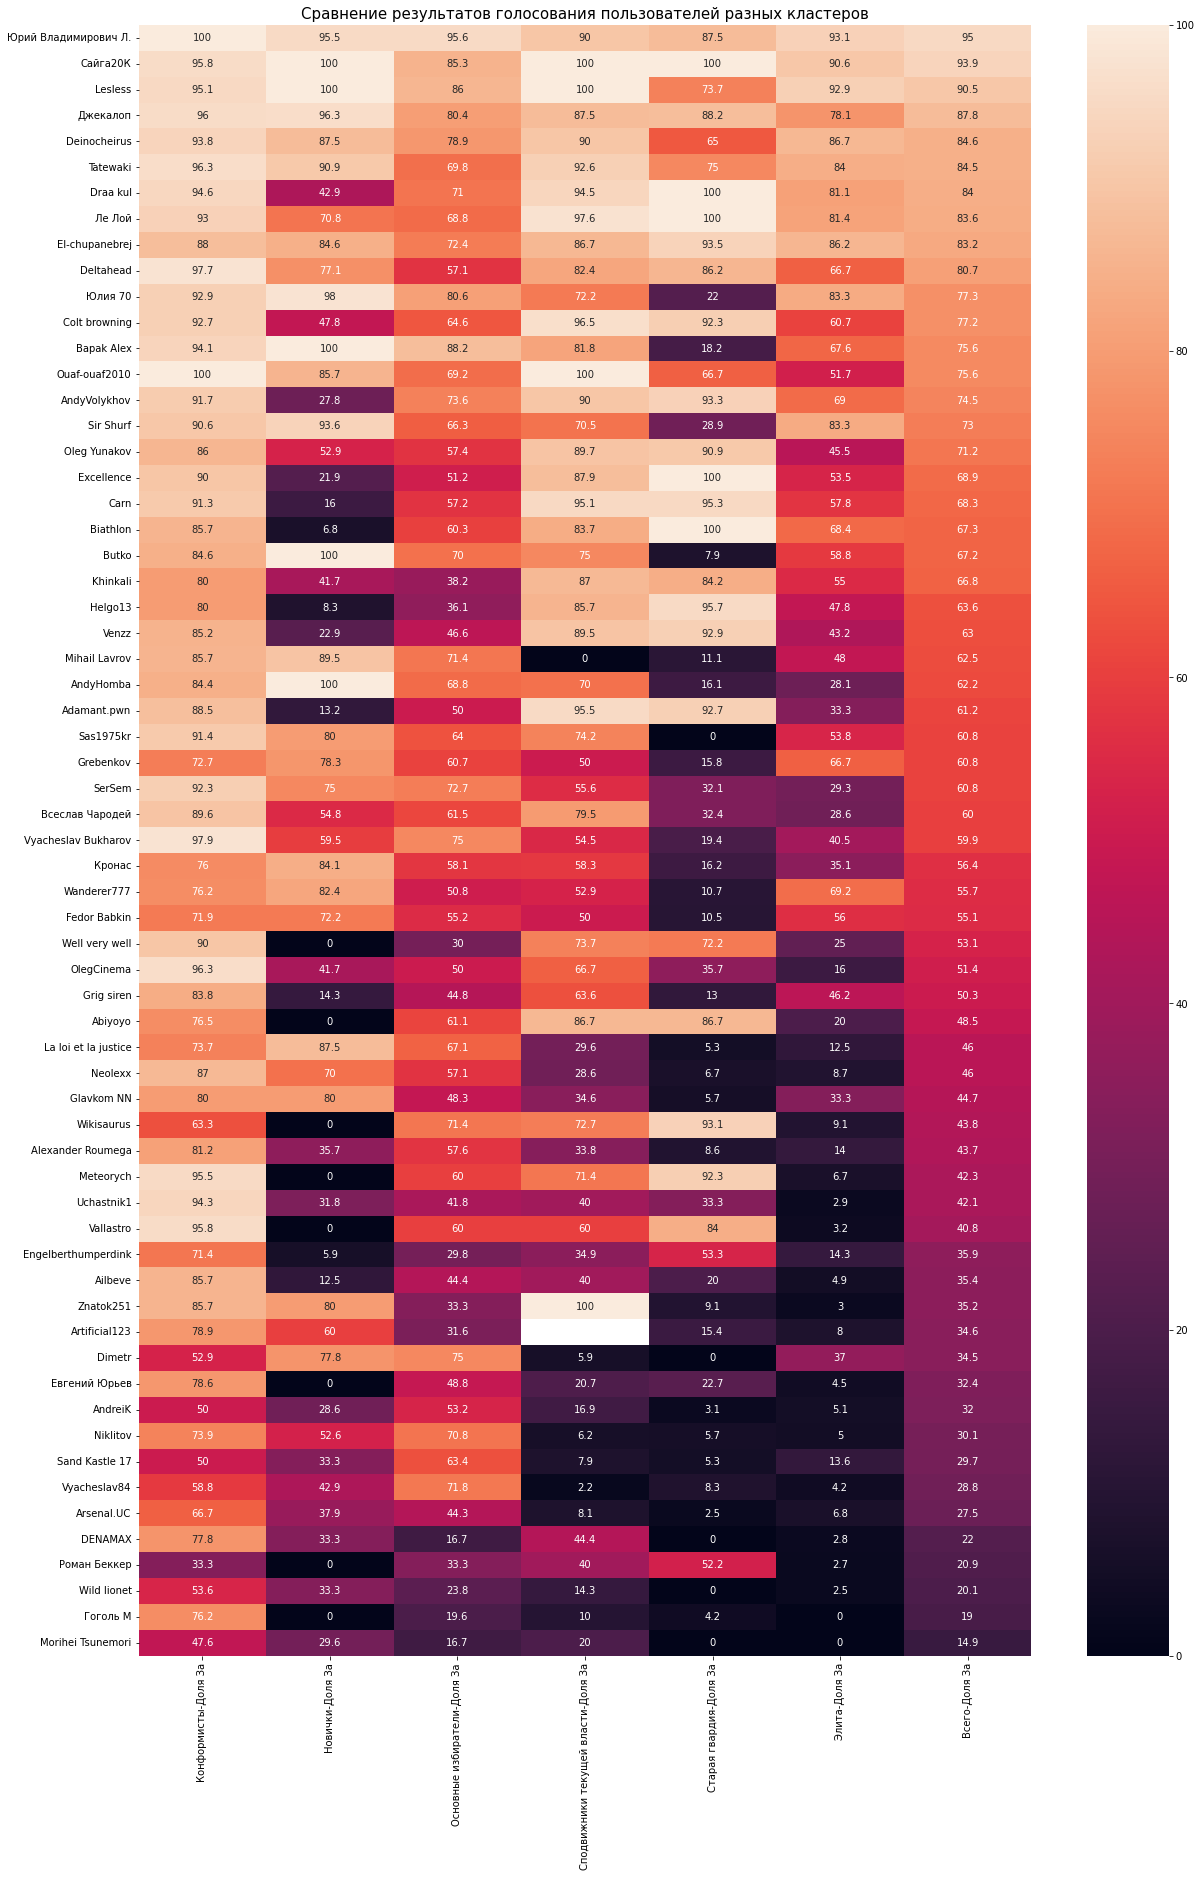

In [60]:
# Сравним результаты голосования кажого кластера между собой

# Отберем данные, для каждого кандидата оставим только последий голос пользователя
df = df_votes.drop_duplicates(subset = ['candidate', 'voter'], keep='last')
elections_result = df.pivot_table(index='candidate', columns=['cluster_name','vote'], values='voter', aggfunc='count').fillna(0)

# Добавим столбец Всего голосов
elections_result1 = elections_result.xs(1, axis=1, level=1) + elections_result.xs(-1, axis=1, level=1)
elections_result1.columns = pd.MultiIndex.from_product([elections_result1.columns, ['Всего']])
elections_result = elections_result.join(elections_result1)

# Посчитаем долю голосов
elections_result2 = ((elections_result.xs(1, axis=1, level=1) / elections_result.xs('Всего', axis=1, level=1))*100).round(1)
elections_result2.columns = pd.MultiIndex.from_product([elections_result2.columns, ['Доля За']])
elections_result = elections_result.join(elections_result2)

# Оставим только информацию о результатах голосования и сравним с результатами по всему датафрейму
elections_result = elections_result.loc[:, (slice(None), 'Доля За')]
elections_result_total = df.pivot_table(index='candidate', columns='vote', values='voter', aggfunc='count').fillna(0)
elections_result_total.columns = ['Против', 'За']
elections_result_total['Всего голосов'] = (elections_result_total['За'] + elections_result_total['Против']).round(1)
elections_result_total['Доля За'] = (elections_result_total['За']/elections_result_total['Всего голосов']*100).round(1)
elections_result_total.columns = pd.MultiIndex.from_product([['Всего'], elections_result_total.columns])
elections_result = elections_result.merge(elections_result_total, on = 'candidate', how='left')
elections_result = elections_result.loc[:, (slice(None), 'Доля За')].sort_values(by = ('Всего', 'Доля За'), ascending=False)

# Построим тепловую карту с долей голосующих пользователей на каждых выборах
plt.figure(figsize=(20,30))
sns.heatmap(elections_result, annot= True, fmt='g', annot_kws={'size': 10})
plt.title('Сравнение результатов голосования пользователей разных кластеров', fontsize=15)
plt.ylabel('')
plt.xlabel('');

**По тепловой карте мы можем сделать следующие выводы:**
1. **Кластер "Конформисты"(кластер 2), действительно самый конформный, по результатам их голосование пороговое значение в 66,6% голосов "За" не проходит всего 7 человек.**
2. **Пользовали кластеров "Старая гвардия" и "Элита", напротив, достаточно часто голосуют против кого-то, большое количество кандидатов по итогам их голосования не набирает и 10%.**
3. **Визуально, результаты голосования кластера "Элита" больше всех похожи на общие результаты по всей выборке,** хотя в этом кластере всего 45 человек. Вероятно, пользователи этого кластера больше всех согласны с результатами голосования.
4. **Все кластеры поддерживают 2х кандидатов: Юрия Владимировича Л и Сайга20К. Вероятно, это самые авторитетные кандидаты.**
5. **Кластеры "Новички" и "Старая гвардия" достаточно часто голосуют абсолютно противоположным образом.** С кандидатом, которого поддерживает оодин кластер, кардинально не согласен другой (подробнее ниже).
6. **Среди других кандидатов-лидеров, набирающих более 70% голосов "За" мы можем отметить следующие особенности:**
- Юлия 70, Bapak Alex, SirShurf имеют низкую поддержку среди пользователей кластера "Старая гвардия"
- AndyVolykhov поддерживают только 27% пользователей кластера "Новички"
- Также менее половины пользователей кластера "Новички" проголосовали за кандидатов Draakul и Colt browning
7. **Среди кандидатов, чьи результаты близки к пороговым значениям (60-70%):**
- Несмотря на том, что Excellence, Carn, Biathlon прошли пороговое значение (за счет поддержки пользователей кластеров "Конформисты", "Сподвижники текущей власти", "Старая гвардия"), эти кандидаты имеют низкую поддержку у пользователей кластера "Новички"
- И, напротив, кандидата Butko единогласно поддерживают пользователи кластера "Новички", но почти кандинально против голосуют пользователи кластера "Старая гвардия"
- Helga13 не набрала нужную долю голосов за счет кластера "Новички", в то время ее поддержало 95,7% пользователей кластера "Старая гвардия"
- Mihail Lavrov для победы не хватило голосов "За" от пользователей кластера "Сподвижники текущей власти" и "Старая гвардия"
- AndyHomba набрал 100% голосов от пользователей кластера "Новички" и только 16% от пользователей кластера "Старая гвардия"
- Adamont.pwn поддерживают 93-96% пользователей кластеров "Сподвижники текущей власти" и "Старая гвардия", и только 13% пользователей кластера "Новички"
- Sas1975kr поддерживает 91,4% пользователей кластера "Сподвижники текущей власти", но единогласно против проголосовали пользователи кластера "Старая гвардия"
8. **Среди результатов кандидатов-аутсайдеров рейтинга (результат менее 30% голосов "За") мы можем отметить:**
- Практически все кандидаты (за редким исключением), итоговый результат которых составил менее 30%, среди пользователей кластеров "Сподвижники текущей власти", "Старая гвардия" и "Элита". не набрали и 10% голосов "За". Исключение Роман Беккер (52% "За" в кластере "Старая гвардия" и 40% в кластере "Сподвижники текущей власти") и DENAMAX (44,4% голосов "За" в кластере "Сподвижники текущей власти")
- При этом практически все кандидаты из списка имеют неплохую поддержку, хоть и недостаточную для победы, среди пользователей кластера "Конформисты" (т.е. по результатам голосования пользователей кластера 2 нет кандидатов, набравших менее 30% голосов "За")
- Среди пользователей кластера "Основные избиратели" 71,8% проголосовали за кандидата Vyacheslav84, хотя в целом по общей выборке кандидат набрал только 28,8% голосов (при этом кластер "Основные избиратели" самый многочисленный кластер, в нем 352 пользователя)

In [61]:
# Рассмотрим, в каких голосованиях участвовали пользователи и из каждого кластера
election_turnout = df_votes.pivot_table(index='n', columns = 'ClusterLabel', values='voter', aggfunc='nunique', margins=True)
election_turnout.columns = ['Кластер 0','Кластер 1','Кластер 2','Кластер 3','Кластер 4','Кластер 5','Всего избирателей']
election_turnout

,Кластер 0,Кластер 1,Кластер 2,Кластер 3,Кластер 4,Кластер 5,Всего избирателей
n,,,,,,,
30,87,31,47,12,22,31,230
31,68,42,53,11,28,37,239
32,51,60,58,26,40,40,275
33,130,20,54,57,36,34,331
34,117,14,38,90,29,32,320
35,73,11,33,64,30,27,238
All,352,60,73,98,43,45,671


Доля пользователей из кластера "Основные избиратели" на выборах составляет 30-40%. Исключение 32 выборы, где приняло участие больше пользователей из кластеров "Новички" и "Конформисты", хотя общая численность пользователей в этом кластере гораздо меньше.\
Пользователи кластера "Элита" практически стабильно участвуют во всех выборах.\
Пользователи кластера "Новички" стали реже принимать участие в выборах, возможно в этом кластере много отваливающихся пользователей.\
Количество пользователей из кластера "Сподвижники текущей власти", напротив растет, это самый набирающий популярность кластер пользователей.

<a id="part9"></a>

### 9. Портрет конформиста и оппортуниста

Ранее в кластерном анализе мы выявили, что среди голосующих пользователей, есть группа пользователей, которые предпочитают голосовать "За" кого-либо (как за победителя, так и за проигравшего), чем "Против" и которым не так важно, кто в результате победит. Вероятно, есть и обратная группа Опортунистов, которые чаще голосуют "Против всех". Пранализируем отдельно всех пользователей по этому признаку и посмотрим, есть ли какие-либо отличительные черты у конформистов и оппортунистов. 

Для сегментации выделим среди пользователей следующие группы:
- Если среди всех голосов пользователя 70% голосов приходится на "За" кого-либо, будем считать его Конформистом
- Если среди всех голосов пользователя 70% голосов приходится на "Против" кого-либо, будем считать его Оппортунистом
- В остальных случаях будем считать, что у пользователя нет четкой позиции по этому признаку, он голосует как "за", так и "против"

In [62]:
(
    df_users.pivot_table(index='conformizm', 
                         values = ['EditsTotal','EditsEdits','EditsAccepted','CreationsPages','CreationsArticles', 
                                   'Months', 'Years', 'avg_duration', 'pages/edits', 'edits_month','pages_month'], 
                         aggfunc='median', 
                         margins=True).round(1)
)

,CreationsArticles,CreationsPages,EditsAccepted,EditsEdits,EditsTotal,Months,Years,avg_duration,edits_month,pages/edits,pages_month
conformizm,,,,,,,,,,,
Опортунист,47.0,216,0.9,7704.0,9758,63.0,5,40.0,123.1,37.5,5.4
Нет позиции,75.5,441,0.9,13287.5,15769,82.0,6,45.0,162.3,41.5,6.4
Конформист,67.0,345,0.9,8959.0,11903,76.0,6,40.0,130.6,41.2,5.8
All,69.0,380,0.9,10951.0,13613,78.5,6,42.5,145.5,40.5,6.1


В результате, мы можем отметить, что **оппортунисты (в 70% случаях голосуют "Против" любого кандидата) являются и самыми неактивными пользователями. Как правило, они гораздо меньше остальных пользователей, как вносят новые правки, так и создают новые страницы. 
В то время, как кандидаты, наиболее активно участвующие в проекте (создают страницы, вносят правки) гораздо более четко понимают, за кого они хотят голосовать.**

<a id="part10"></a>

### 10. Исследовательский анализ пользователей

В этом разделе мы попробуем найти какие-то зависимости в данных пользователя. При этом в нашем датафрейме представлены данные не только по голосующим пользователям, но и дополнительно по всем пользователям, сделавшим более 5000 правок. 

In [63]:
# Рассчитаем коэффициенты корреляции между числовыми столбцами
(
    df_users[['EditsTotal','EditsEdits','EditsAccepted','CreationsPages','CreationsArticles','Months','Years',
              'avg_duration','pages/edits','edits_month','pages_month','supporter_share','сonfzm_share']]
    .corr().style.background_gradient('coolwarm')
)

,EditsTotal,EditsEdits,EditsAccepted,CreationsPages,CreationsArticles,Months,Years,avg_duration,pages/edits,edits_month,pages_month,supporter_share,сonfzm_share
EditsTotal,1.000000,0.956543,-0.220341,0.553393,0.451186,0.353538,0.353841,0.565106,0.127559,0.657858,0.390858,0.078378,-0.013949
EditsEdits,0.956543,1.000000,-0.058841,0.614025,0.487128,0.362406,0.363028,0.554670,0.126798,0.705858,0.456948,0.051804,0.000255
EditsAccepted,-0.220341,-0.058841,1.000000,-0.028774,-0.029242,-0.040498,-0.040646,-0.086330,-0.136592,-0.009625,-0.005768,-0.096775,-0.026188
CreationsPages,0.553393,0.614025,-0.028774,1.000000,0.482074,0.093009,0.094740,0.328527,0.324935,0.720689,0.959662,-0.005367,0.036753
CreationsArticles,0.451186,0.487128,-0.029242,0.482074,1.000000,0.160780,0.161114,0.233476,0.424449,0.341790,0.330115,-0.035087,0.068459
Months,0.353538,0.362406,-0.040498,0.093009,0.160780,1.000000,0.997908,-0.182226,0.032408,-0.088744,-0.021700,0.033550,-0.024085
Years,0.353841,0.363028,-0.040646,0.094740,0.161114,0.997908,1.000000,-0.181723,0.033516,-0.086839,-0.020185,0.035228,-0.027785
avg_duration,0.565106,0.554670,-0.086330,0.328527,0.233476,-0.182226,-0.181723,1.000000,0.046454,0.726651,0.297176,0.064505,-0.020363
pages/edits,0.127559,0.126798,-0.136592,0.324935,0.424449,0.032408,0.033516,0.046454,1.000000,0.140846,0.277830,-0.080825,0.087759
edits_month,0.657858,0.705858,-0.009625,0.720689,0.341790,-0.088744,-0.086839,0.726651,0.140846,1.000000,0.708845,0.033810,0.002661


На основании расчета, сделанного выше, мы можем предположить следующие интересные зависимости:
1. Между данными столбцах 'EditsTotal'/'EditsEdits' (кол-во предложенных правок/кол-во принятых правок) и столбцом 'CreationPages'(кол-во созданных страниц) коэффициент корреляции составляет около 0,6. Это говорит о том, что зачастую, чем больше пользователь внес правок, чем больше у него созданных страниц. Т.е. обычно активные пользователи не являются только авторами или редакторами статей, а занимаются и тем, и другим. 
2. Есть аналогичная взаимосвязь и между полями 'edits_month' (среднее кол-во принятых правок в месяц) и 'pages_month' (кол-во созданных страниц в месяц), при этом в данном случае коффициент корреляции сильнее и составляет 0,7. 
2. Также мы видим взаимосвязь между данными данными столбцах 'EditsTotal'/'EditsEdits' (кол-во предложенных правок/кол-во принятых правок) и столбцом 'avg_duration'(среднее активное время в день), коэффициент корреляции между этими данными составляет около 0,55. Это логично, если пользователь вносит много правок, скорее всего он проводит в Википедии больше времени. 
3. Однако, еще сильнее взаимосвязь между полем 'edits_month' (кол-во принятых правок в месяц) и полем 'avg_duration'(среднее активное время в день). Вероятно, на это отличие в корреляции влияет то, что в нашем датафрейме могут быть данные об уже отвалившихся пользователях, но зарегистрированных давно и в свое время сделавших много правок, а также то, что могут быть активные пользователи, но зарегистрированные недавно. В столбце же 'edits_month' данные не зависят от даты регистрации пользователя и отображают активность пользователя более корректно. Но взаимосвязь мы видим ту же: чем больше принятых правок внес пользователь, чем больше времени он проводит в Википедии. 

Рассмотрим свямосвязи между столбцами edits_month (среднее кол-во принятых правок в месяц), pages_month (среднее кол-во создаваемых страниц в месяц) и avg_duration (среднее активное время в день) более подробно. 

<a id="extra3"></a>

#### Исследовательский анализ. Кол-во правок в месяц и время участия в день.

Для разделения пользователей на сегменты изучим еще раз данные в этих столбцах, чтобы ориентироваться на эти значения при формировании сегментов. 

In [64]:
# Изучим распределение данных в столбцах
df_users[['edits_month','pages_month', 'avg_duration']].describe()

,edits_month,pages_month,avg_duration
count,2828.000000,2828.000000,2828.000000
mean,241.585045,19.604281,55.178571
std,399.216450,166.482660,41.758883
min,0.000000,0.000000,5.000000
25%,76.184992,2.270913,30.000000
50%,137.390398,6.422498,45.000000
75%,274.541746,15.874562,65.000000
max,13443.816327,8634.000000,705.000000


In [65]:
# Разделим пользователей на сегменты в зависимости от кол-ва статей в месяц
df_users['pages_month_segment'] = (
                       pd.cut(df_users['pages_month'], bins=[0, 5, 10, 15, 20, df_users['pages_month'].max()+1], 
                             labels=['менее 5 страниц в месяц', '5-10 страниц в месяц', '10-15 страниц в месяц', 
                                    '15-20 страниц в месяц', '20 статей в месяц и более'], include_lowest=True, right=False) 
)

In [66]:
# Разделим пользователей на сегменты в зависимости от среднего участия в день
df_users['active_time_segment'] = (
                       pd.cut(df_users['avg_duration'], bins=[0, 15, 30, 45, 60, 75, 90, df_users['avg_duration'].max()+1], 
                             labels=['менее 15 минут', '15-30 минут', '30-45 минут', '45-60 минут', '60-75 минут',
                                    '75-90 минут', '90 минут и более'], include_lowest=True, right=False) 
)

In [67]:
# Разделим пользователей на сегменты в зависимости от кол-ва принятых правок в месяц
df_users['edits_month_segment'] = (
                       pd.cut(df_users['edits_month'], bins=[0, 100, 200, 300, df_users['edits_month'].max()+1], 
                             labels=['менее 100 правок в месяц', '100-200 правок в месяц', '200-300 правок в месяц', 
                                    '300 правок в месяц и более'], include_lowest=True, right=False) 
)

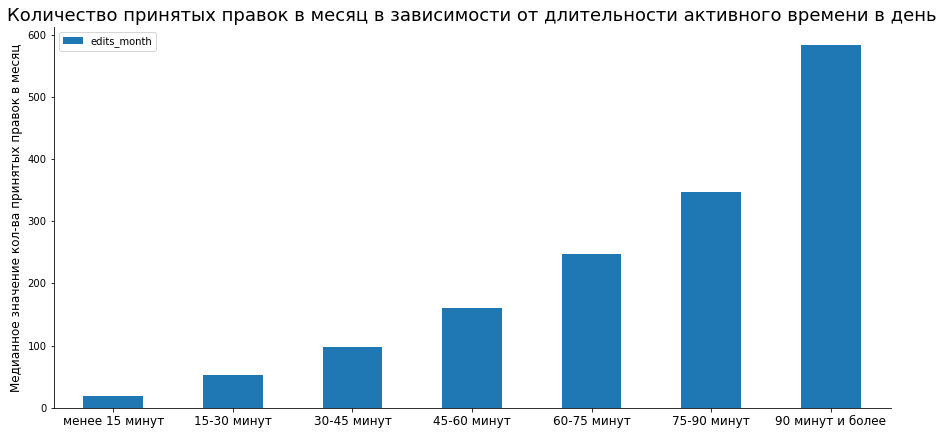

In [68]:
# Рассчитаем медианное значение кол-ва принятых правок в зависимости от времени и построим визуализацию
df_users.pivot_table(index='active_time_segment', values='edits_month', aggfunc = 'median')\
        .sort_values(by='edits_month')\
        .plot(kind='bar', figsize=(15,7))
plt.title('Количество принятых правок в месяц в зависимости от длительности активного времени в день', fontsize=18)
plt.xticks(rotation=0, fontsize = 12)
plt.ylabel('Медианное значение кол-ва принятых правок в месяц', fontsize=12)
plt.xlabel('')
sns.despine();   

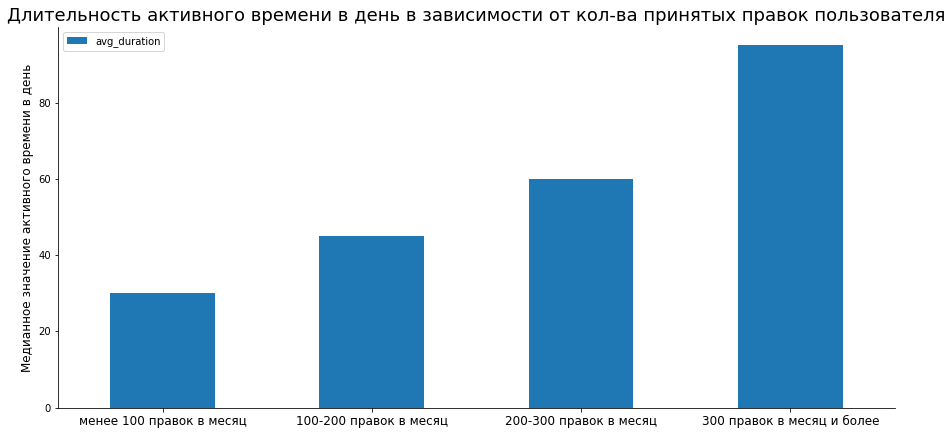

In [69]:
# Рассчитаем медианное значение времени, которое проводит пользователь, в зависимости от кол-ва правок и построим визуализацию
df_users.pivot_table(index='edits_month_segment', values='avg_duration', aggfunc = 'median')\
        .sort_values(by='avg_duration').plot(kind='bar', figsize=(15,7));
plt.title('Длительность активного времени в день в зависимости от кол-ва принятых правок пользователя', fontsize=18)
plt.xticks(rotation=0, fontsize = 12)
plt.ylabel('Медианное значение активного времени в день', fontsize=12)
plt.xlabel('')
sns.despine();

**Вывод:**\
**Чем больше пользователь вносит правок в месяц, тем больше времени он проводит в Википедии.**\
Пользователи, вносящие менее 100 правок в месяц, проводят в Википедии не более 30 минут в день, в то время, как пользователи, от которых поступает более 300 правок в месяц, проводят в Википедии более 1,5 часов в день.\
И наоборот: пользователи, которые проводят в Википедии менее 15 минут, как правило, вносят 52 правки в месяц, для пользователей проводящих в Википедии 1,5 часа и более в день медианное значение кол-ва принятых правок в месяц составляет 583. 

<a id="extra4"></a>

#### Исследовательский анализ. Кол-во правок в месяц и кол-во созданных страниц в месяц. 

Рассмотрим взаимосвязь между количеством принятых правок в месяц (edits_month) и кол-вом созданных пользователем страниц (pages_month).

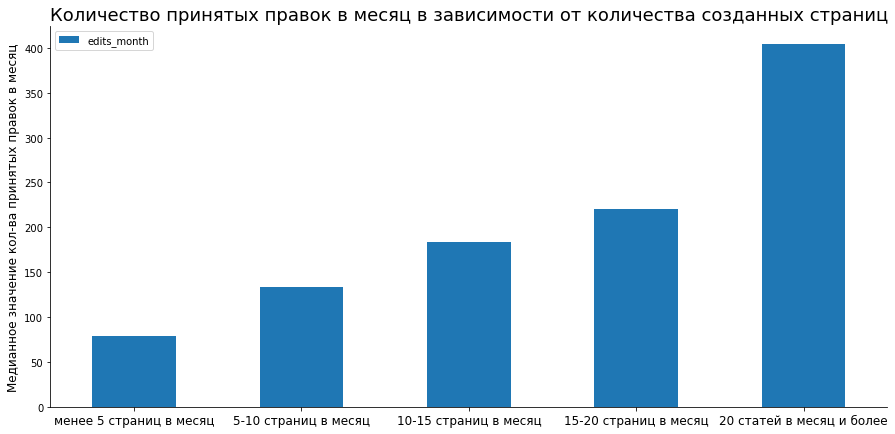

In [70]:
# Рассчитаем медианное значение кол-ва принятых правок в зависимости от кол-во созданных страниц
df_users.pivot_table(index='pages_month_segment', values='edits_month', aggfunc = 'median')\
        .sort_values(by='edits_month').plot(kind='bar', figsize=(15,7))
plt.title('Количество принятых правок в месяц в зависимости от количества созданных страниц', fontsize=18)
plt.xticks(rotation=0, fontsize = 12)
plt.ylabel('Медианное значение кол-ва принятых правок в месяц', fontsize=12)
plt.xlabel('')
sns.despine();   

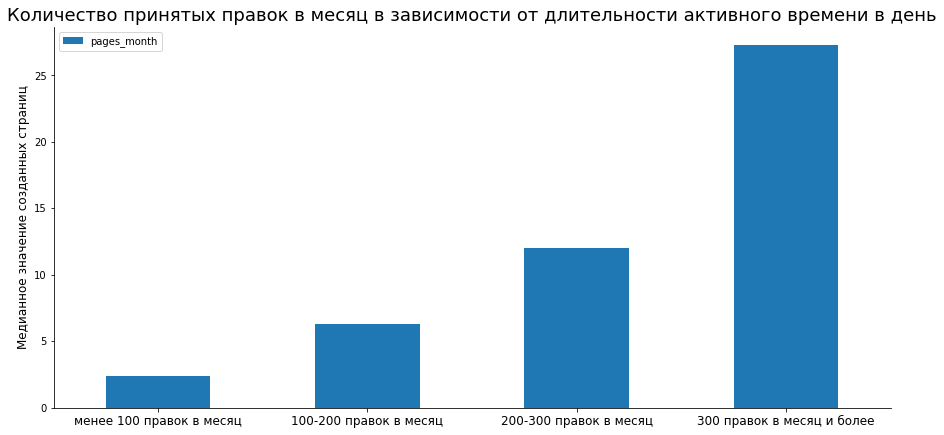

In [71]:
# Рассчитаем медианное значение кол-ва принятых правок в зависимости от времени и построим визуализацию
df_users.pivot_table(index='edits_month_segment', values='pages_month', aggfunc = 'median')\
        .sort_values(by='pages_month').plot(kind='bar', figsize=(15,7));
plt.title('Количество принятых правок в месяц в зависимости от длительности активного времени в день', fontsize=18)
plt.xticks(rotation=0, fontsize = 12)
plt.ylabel('Медианное значение созданных страниц', fontsize=12)
plt.xlabel('')
sns.despine();

**Вывод:**\
**Пользователи, которые создают много новых страниц, как правило, вносят и много правок.**\
В частности, пользователи, создающие менее 5 новых страниц в месяц, вносят при этом всего 78 принятых правок в месяц, в то время, как пользователи, создающие более 20 новых страниц в месяц, вносят 403 принятых правки в месяц.\
И наоборот: пользователи, вносящие менее 100 правок в месяц, как правило, создают при этом всего 2 новые страницы, а пользователи, вносящие более 300 правок в месяц, при этом создают по 27 страниц в месяц. 

#### Исследовательский анализ. Кол-во созданных страниц в месяц и время участия в день.

Несмотря на высокий коэффициент корреляции edits_month(кол-во принятых правок в месяц)/avg_duration(среднее время участия в день) и pages_month(среднее кол-во новых страниц в месяц)/edits_month(среднее кол-во принятых правок в месяц), коэффициент корреляции между столбцами pages_month(среднее кол-во новых страниц в месяц) и avg_duration(среднее время участия в день) низкий и составляет всего 0,3. 
Рассмотрим данные в таком разрезе тоже и проверим это. 

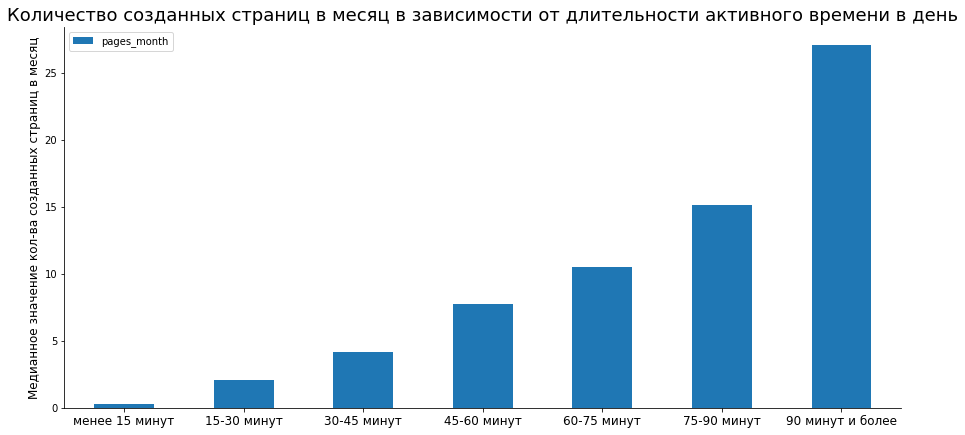

In [72]:
# Рассчитаем медианное значение времени, которое проводит пользователь, в зависимости от кол-ва страниц и построим визуализацию
df_users.pivot_table(index='active_time_segment', values='pages_month', aggfunc = 'median')\
         .sort_values(by='pages_month').plot(kind='bar', figsize=(15,7))
plt.title('Количество созданных страниц в месяц в зависимости от длительности активного времени в день', fontsize=18)
plt.xticks(rotation=0, fontsize = 12)
plt.ylabel('Медианное значение кол-ва созданных страниц в месяц', fontsize=12)
plt.xlabel('')
sns.despine(); 

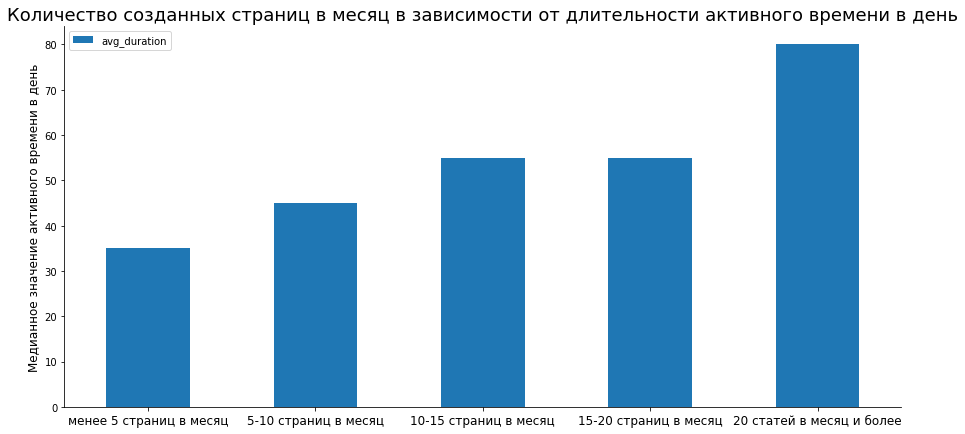

In [73]:
# Рассчитаем медианное значение времени, которое проводит пользователь, в зависимости от кол-ва страниц и построим визуализацию
df_users.pivot_table(index='pages_month_segment', values='avg_duration', aggfunc = 'median')\
        .sort_values(by='avg_duration').plot(kind='bar', figsize=(15,7))
plt.title('Количество созданных страниц в месяц в зависимости от длительности активного времени в день', fontsize=18)
plt.xticks(rotation=0, fontsize = 12)
plt.ylabel('Медианное значение активного времени в день', fontsize=12)
plt.xlabel('')
sns.despine(); 

Действительно, для некоторых сегментов мы можем говорить о такой взаимосвязи, но для пользователей, создающих 10-20 страниц в месяц эта взаимосвязь почти отсутствует.\
На верхней диаграмме мы действительно видим, что чем больше времени в день пользователь проводит в Википедии, тем больше новых страниц он создает (также как и больше новых правок в статьи). В частности, пользователь проводящий в среднем 15-30 минут создает около 2 статей в месяц, а пользователь, проводящий в среднем 1,5 часа в день - 27 новых страниц.\
Однако, на нижней диаграмме, мы с одной стороны также видим, что пользователь, создающий менее 5 страниц, проводит в Википедии 35 минут в день, а пользователь создающий более 20 новых страниц - 80 минут в день. Однако, пользователи, создающие 10 страниц и пользователи, создающие 20 страниц в месяц проводят одинаковое кол-во времени в день - 55 минут, т.е. для такого сегмента взаимосвязь между количество новых страниц и активным временем отсутствует. 

Однако, поскольку корреляция между количеством новых страниц и активным временем в день низкая, интересно рассмотреть, сколько в среднем проводят времени в день пользователи, которые предпочитают больше создавать новые страницы, чем править и пользователи, которые, напротив, вносят много правок, но реже создают новые. Для этого мы разделим пользователей на 2 сегмента: Авторы и Редакторы. 

<a id="extra5"></a>

#### Активное время участия в день авторов страниц и редакторов

Для проведения сегментации будем считать, что если пользователь создает 50 и более новых страниц на 1000 предложенных им правок, он скорее предпочитает создавать новые страницы и считается Автором. В обратном случае - Редактором. 

In [74]:
# Разделим пользователей на сегменты в зависимости от кол-ва статей на 1000 правок
df_users['editor/author'] = (
                       pd.cut(df_users['pages/edits'], bins=[0, 50, df_users['pages/edits'].max()+1], 
                             labels=['Редактор статей', 'Автор страниц'], include_lowest=True, right=False) 
)

In [75]:
# Посмотрим, сколько времени в среднем тратят в проекте Авторы и Редакторы статей
df_users.groupby('editor/author')[['avg_duration']].median()

,avg_duration
editor/author,
Редактор статей,45.0
Автор страниц,45.0


Таким образом, мы видим, что **Авторы и Редакторы проводят в Википедии одинаковое время - 45 минут в день.**

<a id="part11"></a>

### 11. Выводы

В этом проекте мы проанализировали результаты 6 выборов проекта Википедии, выявили взаимосвязи между данными, провели кластеризацию голосующих пользователей и составили их портрет. По результатам нашего анализа мы можем сделать следующие выводы:

**1. Итоги выборов** [Подробнее](#part4)\
Выборы проводятся каждые полгода.\
При этом в 32 выборах участвовало наибольшее кол-во кандидатов - 28 человек.\
По кол-ву избирателей самые активные выборы - 33 и 34, в них участвовало более 320 избирателей.\
В 2020-2021 году каждый кандидат получал 134-135 голосов, в 33-34 выборах при росте кол-ва избирателей кол-во голосов выросло.\
**В среднем 1 пользователь голосует за 50-60% кандидатов, а в остальных случаях воздерживается.**\
**По итогам каждых выборов необходимый порог для победы (2/3 голосов "За") проходит 6-7 человек.** Исключение - 35 выборы, где нужную отметку прошло только 4 кандидата из 11 (при этом в 35 выборах участвовало минимальное кол-во кандидатов по сравнению с другими выборами).\
23 кандидата из 63 участвовали в нескольких выборах (максимальное значение - 4 голосования).Чаще всего результат таких кандидатов одинаков. Однако, для 10 кандидатов результаты выборов отличаются: Adamant.pwn(2 победы из 4х выборов), Carn (2 из 3), Excellence(2 из 4), Oleg Yunakov(1 из 2), SerSem(1 из 2), Sir Shurf(1 из 2), Venzz(1 из 4), Vyacheslav Bukharov(1 из 2), Всеслав Чародей(1 из 2), Кронас(1 из 2).

In [76]:
elections_info

,Начало выборов,Окончание выборов,Кол-во кандидатов,Кол-во избирателей,Кол-во голосов всего,Среднее кол-во голосов на кандидата,За сколько кандидатов голосует 1 пользователь,"За какой процент кандидатов голосует 1 пользователь, %"
n,,,,,,,,
30,2020-07-30,2020-08-05,14,230,1879,134.0,8.0,57.1
31,2021-01-30,2021-02-05,13,239,1750,135.0,7.0,53.8
32,2021-07-30,2021-08-05,28,275,4094,146.0,15.0,53.6
33,2022-01-30,2022-02-05,17,331,3283,193.0,10.0,58.8
34,2022-07-30,2022-08-05,15,320,3123,208.0,10.0,66.7
35,2023-01-30,2023-02-05,11,238,1847,168.0,8.0,72.7


**2. Результаты выборов по дням голосования** [Подробнее](#part5)

**Практически половина всех избирателей голосует в первый же день выборов.** В 31 выборах активное голосование также происходило на 2ой день голосования. 

**В последний день голосования пользователи активизируются и активность в голосовании на уровне 2го дня.**

При этом **результаты 1го дня голосования определяют итоги всех выборов** и к концу голосования результат практически не меняется. Тем не менее, в каждых выборах (кроме 35) есть кандидат, для которого результат кардинально менялся во 2ой-7ой день голосования.

**В среднем окончательный результат голосования отличается от результатов 1го дня всего на 2,3%.**

При этом **для 5 кандидатов разница результатов 1го дня голосования и 7го стала решающей.**\
Adamant.pwn(30 выборы) и Кронас(31 выборы) по итогам 1го дня голосования не набирали необходимого количества голосов "За" для победы, однако в процессе голосования донабрали необходимое кол-во и прошли.\
AndyHomba(32 выборы), Sir Shurf(33 выборы), Helgo13(34 выборы) напротив, по итогам 1го дня побеждали, однако в результате доля голосов "За" оказалась ниже порогового значения. Но стоит отметить, что даже после 1го дня голосования результаты этих кандидатов были близки к пороговым значениям, т.е. кардинального изменения хода выборов нет.

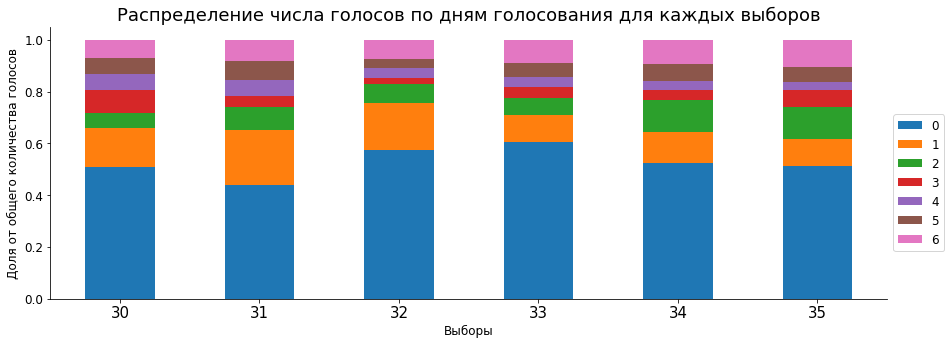

In [77]:
day_elections.T.plot.bar(stacked=True, figsize = (15,5))
plt.title('Распределение числа голосов по дням голосования для каждых выборов', fontsize=18)
plt.ylabel('Доля от общего количества голосов', fontsize=12)
plt.xlabel('Выборы', fontsize=12)
plt.xticks(fontsize = 15, rotation=0)
plt.yticks(fontsize = 12)
plt.legend(bbox_to_anchor=(1.0, 0.7), loc='upper left', fontsize=12)
sns.despine();

**3. Распределение типа голоса по дням голосования** [Подробнее](#extra1)

**В последние дни голосования есть попытки "вытянуть" результаты кандидата.** Анализируя результаты проигравшего кандидата, можно заметить, что в 1ый и 2ой день голосования избиратели активнее голосуют "Против" кандидата. Однако, в последние дни голосования ситуация меняется - кол-во голосов "За" становится немного выше, чем "Против".

Также можно отметить общую разницу в голосовании 2го и последнего дня. Активность голосования в последний день практически на уровне 2го дня. Однако, **количество голосов "За" (как за победителя, так и за проигравшего) в последний день даже выше, чем во 2ой день. Количество голосов "Против" (как против победителя, так и против проигравшего) в последний день, напротив, ниже по сравнению со 2ым.**




In [78]:
day_type

result                       Победил                          \
vote_result      Голос за победителя Голос против победителя   
day_of_elections                                               
0                              17.40                    4.97   
1                               4.89                    1.46   
2                               2.90                    0.85   
3                               1.70                    0.48   
4                               1.61                    0.36   
5                               1.83                    0.63   
6                               3.03                    0.70   

result                        Проиграл                            
vote_result      Голос за проигравшего Голос против проигравшего  
day_of_elections                                                  
0                                12.69                     19.05  
1                                 3.39                      4.72  
2                                 2.54                      2.40  
3                                 1.10                      1.34  
4                                 1.13                      1.03  
5                                 1.60                      1.47  
6                                 2.55                      2.17

**4. Количество набранных голосов для победы** [Подробнее](#part6)

В среднем на каждых выборах в среднем кандидат набирает 134-208 голосов. Однако, **победители выборов набирают на 23-55 (в зависимости от выборов) больше голосов, чем проигравшие. Т.е. люди более активно голосуют за тех, кого хотят видеть, чем против кого-то.**

**Также голосование проходит активно за кандидатов, чьи результаты близки к пороговым значениям (60-70%).**



In [79]:
vote_qnt

,n,result,Кол-во кандидатов,Кол-во голосов,Кол-во голосов на 1 кандидата
0,30,Победил,7,1044,149
1,30,Проиграл,7,835,119
2,31,Победил,7,1068,152
3,31,Проиграл,6,682,113
4,32,Победил,7,1312,187
5,32,Проиграл,21,2782,132
6,33,Победил,6,1341,223
7,33,Проиграл,11,1942,176
8,34,Победил,6,1347,224
9,34,Проиграл,9,1776,197


**5. Консервативность избирателей** [Подробнее](#part7)

**Пользователи достаточно консервативны и в 80% сохраняют свой голос за кандидата на следующих выборах.**

Но примечательно, что **при изменении голос чаще менялся в худшую сторону, т.е. бывают случаи, когда кандидат не оправдал ожидания пользователя.**

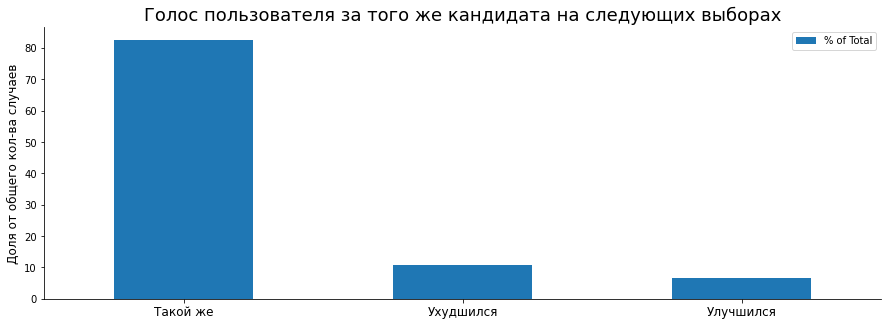

In [80]:
past_elections.pivot_table(index='past_vote_type', values='vote', aggfunc = 'count')\
              .assign(**{'% of Total': lambda x: x['vote'] / x['vote'].sum() * 100})\
              .sort_values(by='vote', ascending=False)\
              .plot(y='% of Total', kind='bar', figsize=(15,5))
plt.title('Голос пользователя за того же кандидата на следующих выборах', fontsize=18)
plt.xticks(rotation=0, fontsize = 12)
plt.ylabel('Доля от общего кол-ва случаев', fontsize=12)
plt.xlabel('')
sns.despine();

In [81]:
cluster_stats.rename(index={0:'Основные избиратели',1:'Новички',2:'Конформисты',3:'Сподвижники текущей власти',4:'Старая гвардия', 5:'Элита','All':'Общая характеристика'}, inplace=True)
cluster_stats

,Кол-во энциклопедических статей,Кол-во созданных страниц всего,Доля принятых правок,Кол-во принятых правок,Кол-во предложенных правок,"Участие в проекте, мес","Участие в проекте, лет",Активное время в день,Кол-во правок в месяц,Кол-во созданных страниц на 1000 правок,Кол-во страниц в месяц
ClusterLabel,,,,,,,,,,,
Основные избиратели,67.0,291.5,0.902375,7910.0,9002.5,68.0,5.0,40.0,120.982843,43.700315,4.960597
Новички,47.5,135.0,0.912472,6213.5,10589.5,46.0,3.5,45.0,95.449783,27.875000,2.615616
Конформисты,122.0,733.0,0.788497,21331.0,27270.0,106.0,8.0,50.0,194.193548,35.766730,6.329787
Сподвижники текущей власти,41.0,345.0,0.806991,8124.0,10668.0,71.0,5.0,40.0,139.900826,42.142857,5.910448
Старая гвардия,71.0,746.5,0.707815,16153.5,26952.5,124.5,10.0,45.0,182.706354,42.413425,8.589286
Элита,191.5,1417.5,0.789304,34239.5,46520.5,140.0,11.0,55.0,260.673950,38.405722,12.022714
Общая характеристика,69.0,380.0,0.875000,10951.0,13613.0,78.5,6.0,42.5,145.456199,40.537368,6.075647


In [82]:
type_vote.columns = ['Основные избиратели','Новички','Конформисты','Сподвижники текущей власти','Старая гвардия', 'Элита']
type_vote

,Основные избиратели,Новички,Конформисты,Сподвижники текущей власти,Старая гвардия,Элита
vote_result,,,,,,
Голос за победителя,30.6,30.7,43.2,39.9,29.3,26.1
Голос за проигравшего,27.6,19.9,41.1,25.1,19.7,12.7
Голос против победителя,14.9,13.1,4.2,4.1,8.1,11.5
Голос против проигравшего,26.9,36.3,11.5,31.0,43.0,49.8


**6. Кластерный анализ пользователей, участвующих в голосовании** [Подробнее](#part8)

Мы разделили пользователей на 6 кластеров:
1. **Основные избиратели** (352 человека). Это самый большой кластер и их распределение голосов ближе всего к общему. Однако, примечательно, что именно в этом кластере наибольшая доля голосов "Против победителя" и достаточно большая доля голосов "За проигравшего". Т.е. среди пользователей этого кластера могут быть несогласные с результатами выборов.
2. **Новички** (60 человек). Это самые "молодые" пользователи проекта, медианное значение их участия - 3, 5 года. Они редко создают какие-либо новые страницы (2-3 шт в месяц), предпочитают больше вносить правки в имеющиеся. Пользователи этого кластера чаще голосуют "Против проигравшего", чем "За победителя". Результаты в их голосования в разрезе по типу голоса близки к результатам голосования пользователей кластера "Старая гвардия", однако, в реальности их голоса зачастую полностью противоположны.
3. **Конформисты** (73 человека). Активные участники проекта, зарегистрированные около 8 лет. Активно как создают страницы, так и вносят правки в имеющееся. В среднем проводят в Википедии 50 минут в день, один из самых высоких показателей среди кластеров. Не любят голосовать против кого-то, 84,3% от всех их голосов составляют голоса "За". По результатам голосования пользователей этой группы нет кандидатов, которые не набирали хотя бы 33% голосов поддержки, а пороговое значение в 66,6% голосов "За" не проходит всего 7 человек. Вероятно, в большинстве случаев они просто голосуют за всех и им неважно кто победит.
4. **Сподвижники текущей власти** (98 человек). Они участвуют в создании новых страниц, но не энциклопедических, и реже, по сравнению с другими кластерами вносят какие-либо правки. В среднем проводят в Википедии 40 минут в день (ниже среднего).После конформистов, которые голосуют просто за всех, в этой группе больше, чем в других, доля голосов "За победителя".
5. **Старая гвардия** (43 человека). Активно участвуют в создании новых страниц, но не энциклопедических, но больше предпочитают вносить правки в имеющиеся, при этом их правки часто отклоняются (принимается только 60% от вносимых правок). Чаще голосуют "Против проигравшего", чем "За победителя". Большое количество кандидатов по итогам их голосования не набирает и 10%. В распределении по типу голоса результаты этой группы похожи на кластер "Элита", но "мягче". Результаты голосования часто противоположны результатам голосования кластера "Новички". 
6. **Элита** (45 человек). Самые "старые", но при этом и самые активные участники проекта. Ежемесячно создают по 12 новых страниц, активно как создают энциклопедические страницы, так и правят имеющиеся. Проводят в Википедии 55 минут в день.Основная стратегия пользователей этого кластера не допустить до победы тех, кто им не нравится, при этом они достигают своей цели, т.к. почти половину всех голосов составляют голоса "Против проигравшего". Большое количество кандидатов по итогам их голосования не набирает и 10%. Пользователи этой группы больше всех "довольны" результатами выборов по соотношению долей "За победителя" + "Против проигравшего", при этом у них самая низкая доля конформизма при принятии решения.

**7. Особенности голосования каждого кластера в разрезе по кандидатам** [Подробнее](#extra2)

**Все кластеры поддерживают 2х кандидатов: Юрия Владимировича Л и Сайга20К.** Вероятно, это самые авторитетные кандидаты. 

**Кластеры "Новички" и "Старая гвардия" достаточно часто голосуют абсолютно противоположным образом.** С кандидатом, которого поддерживает оодин кластер, кардинально не согласен другой (подробнее ниже). 

**Среди других кандидатов-лидеров, набирающих более 70% голосов "За" мы можем отметить следующие особенности:** 
- Юлия 70, Bapak Alex, SirShurf имеют низку поддержку среди пользователей кластера "Старая гвардия" AndyVolykhov поддерживают только 27% пользователей кластера "Новички" 
- Также менее половины пользователей кластера "Новички" проголосовали за кандидатов Draakul и Colt browning 

**Среди кандидатов, чьи результаты близки к пороговым значениям (60-70%):**
- Несмотря на том, что Excellence, Carn, Biathlon прошли пороговое значение (за счет поддержки пользователей кластеров "Конформисты", "Сподвижники текущей власти", "Старая гвардия"), эти кандидаты имеют низкую поддержку у пользователей кластера "Новички"
- И, напротив, кандидата Butko единогласно поддерживают пользователи кластера "Новички", но почти кандинально против голосуют пользователи кластера "Старая гвардия" 
- Helga13 не набрала нужную долю голосов за счет кластера "Новички", в то время ее поддержало 95,7% пользователей кластера "Старая гвардия" 
- Mihail Lavrov для победы не хватило голосов "За" от пользователей кластера "Сподвижники текущей власти" и "Старая гвардия" 
- AndyHomba набрал 100% голосов от пользователей кластера "Новички" и только 16% от пользователей кластера "Старая гвардия" 
- Adamont.pwn поддерживают 93-96% пользователей кластеров "Сподвижники текущей власти" и "Старая гвардия", и только 13% пользователей кластера "Новички" 
- Sas1975kr поддерживает 91,4% пользователей кластера "Сподвижники текущей власти", но единогласно против проголосовали пользователи кластера "Старая гвардия" 

**Среди результатов кандидатов-аутсайдеров рейтинга (результат менее 30% голосов "За") мы можем отметить:**
- Практически все кандидаты (за редким исключением), итоговый результат которых составил менее 30%, среди пользователей кластеров "Сподвижники текущей власти", "Старая гвардия" и "Элита". не набрали и 10% голосов "За". Исключение Роман Беккер (52% "За" в кластере "Старая гвардия" и 40% в кластере "Сподвижники текущей власти") и DENAMAX (44,4% голосов "За" в кластере "Сподвижники текущей власти") 
- При этом практически все кандидаты из списка имеют неплохую поддержку, хоть и недостаточную для победы, среди пользователей кластера "Конформисты" (т.е. по результатам голосования пользователей кластера 2 нет кандидатов, набравших менее 30% голосов "За") 
- Среди пользователей кластера "Основные избиратели" 71,8% проголосовали за кандидата Vyacheslav84, хотя в целом по общей выборке кандидат набрал только 28,8% голосов (при этом кластер "Основные избиратели" самый многочисленный кластер, в нем 352 пользователя)

**8. Портрет конформиста и оппортуниста** [Подробнее](#part9)

**Оппортунисты (в 70% случаях голосуют "Против" любого кандидата) являются и самыми неактивными пользователями.** Как правило, они гораздо меньше остальных как вносят новые правки, так и создают новые страницы. 

В то же время, **кандидаты, наиболее активно участвующие в проекте (создают страницы, вносят правки) гораздо более четко понимают, за кого они хотят голосовать.**

In [83]:
cnfmzm = df_users.pivot_table(index='conformizm', values = ['EditsTotal','EditsEdits','CreationsPages','CreationsArticles', 'Years', 'avg_duration', 'pages/edits', 'edits_month','pages_month'], aggfunc='median', margins=True)
cnfmzm.columns = ['Кол-во энциклопедических статей', 'Кол-во созданных страниц всего', 'Кол-во принятых правок', 'Кол-во предложенных правок', 'Участие в проекте, лет', 'Активное время в день', 'Кол-во правок в месяц', 'Кол-во созданных страниц на 1000 правок', 'Кол-во страниц в месяц']
cnfmzm

,Кол-во энциклопедических статей,Кол-во созданных страниц всего,Кол-во принятых правок,Кол-во предложенных правок,"Участие в проекте, лет",Активное время в день,Кол-во правок в месяц,Кол-во созданных страниц на 1000 правок,Кол-во страниц в месяц
conformizm,,,,,,,,,
Опортунист,47.0,216,7704.0,9758,5,40.0,123.078049,37.534660,5.411765
Нет позиции,75.5,441,13287.5,15769,6,45.0,162.329778,41.461130,6.428803
Конформист,67.0,345,8959.0,11903,6,40.0,130.623596,41.158104,5.850000
All,69.0,380,10951.0,13613,6,42.5,145.456199,40.537368,6.075647


**9. Чем больше пользователь вносит правок в месяц, тем больше времени он проводит в Википедии.** [Подробнее](#extra3)

Пользователи, вносящие менее 100 правок в месяц, проводят в Википедии не более 30 минут в день, в то время, как пользователи, от которых поступает более 300 правок в месяц, проводят в Википедии более 1,5 часов в день.
И наоборот: пользователи, которые проводят в Википедии менее 15 минут, как правило, вносят 52 правки в месяц, для пользователей проводящих в Википедии 1,5 часа и более в день медианное значение кол-ва принятых правок в месяц составляет 583.

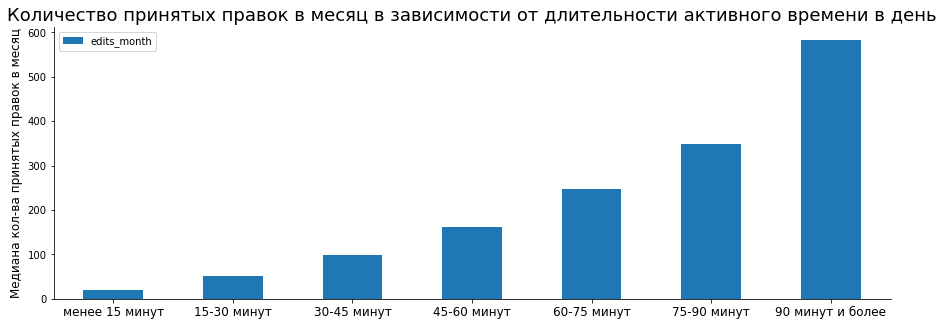

In [84]:
df_users.pivot_table(index='active_time_segment', values='edits_month', aggfunc = 'median')\
        .sort_values(by='edits_month').plot(kind='bar', figsize=(15,5))
plt.title('Количество принятых правок в месяц в зависимости от длительности активного времени в день', fontsize=18)
plt.xticks(rotation=0, fontsize = 12)
plt.ylabel('Медиана кол-ва принятых правок в месяц', fontsize=12)
plt.xlabel('')
sns.despine();  

**10. Пользователи, которые создают много новых страниц, как правило, вносят и много правок.** [Подробнее](#extra4)

В частности, пользователи, создающие менее 5 новых страниц в месяц, вносят при этом всего 78 принятых правок в месяц, в то время, как пользователи, создающие более 20 новых страниц в месяц, вносят 403 принятых правки в месяц.\
И наоборот: пользователи, вносящие менее 100 правок в месяц, как правило, создают при этом всего 2 новые страницы, а пользователи, вносящие более 300 правок в месяц, при этом создают по 27 страниц в месяц. 


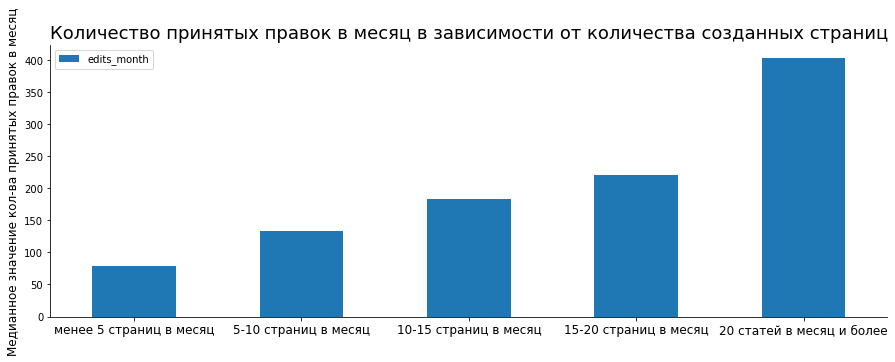

In [85]:
df_users.pivot_table(index='pages_month_segment', values='edits_month', aggfunc = 'median')\
        .sort_values(by='edits_month').plot(kind='bar', figsize=(15,5))
plt.title('Количество принятых правок в месяц в зависимости от количества созданных страниц', fontsize=18)
plt.xticks(rotation=0, fontsize = 12)
plt.ylabel('Медианное значение кол-ва принятых правок в месяц', fontsize=12)
plt.xlabel('')
sns.despine();  

**11. Авторы страниц и Редакторы проводят в Википедии одинаковое время - 45 минут в день** [Подробнее](#extra5)

In [86]:
df_users.groupby('editor/author')[['avg_duration']].median()

,avg_duration
editor/author,
Редактор статей,45.0
Автор страниц,45.0
